<a href="https://colab.research.google.com/github/dudu1626/entrega_trabalho_redes_neurais/blob/main/01_problema_multiclasses_entrega_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho aprendizagem profunda
_Professor: Pedro Nuno_<br>
_Alunos: Eduardo e Nelson_

**Objetivo**: Usando o dataset HAM10000, desenvolver modelo de aprendizagem profunda para classificação de doenças de pele através de imagens dermatoscópicas.

**Nossa proposta neste trabalho é o desenvolvimento de redesd de aprendizagem profunda trinadas do zero.<br>Uma oportunidade de observar na prática os conhecimentos adiquiridos nas aulas e perceber as diferenças de nos resultados dos modelos ao manipular a arquitetura das redes, observar as necessidades de processamento e a dificuldade de obtenção de dados de qualidade.**

## 1. Importação bibliotecas, configurações ambiente e funções personalizadas

Bibliotecas

In [ ]:
# manipulação de dados tabulares
import pandas as pd
import numpy as np

# visualização
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# sklearning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# TensorFlow
import tensorflow as tf
from tensorflow import keras

2024-12-17 07:31:24.034658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 07:31:24.124627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 07:31:24.150071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 07:31:24.157195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 07:31:24.246719: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# ferramentas para manipulação imagens
import zipfile
from zipfile import ZipFile

import os

Configurações

In [ ]:
# config visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("darkgrid")

In [ ]:
# conferência para ver se o ambiente do Colab está habilitado com GPU (fica bem mais rápido o processamento com a GPU ativa)
print("A GPU está", "disponível" if tf.config.list_physical_devices('GPU') else "NÃO está disponível")

A GPU está disponível


I0000 00:00:1734431486.389057     451 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734431486.584070     451 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734431486.584154     451 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Variáveis globais

In [ ]:
SEED = 39
BATCH_SIZE = 32
IMAGE_SIZE = (120, 120)

Funções

In [ ]:
# criação de um dataframe com os dados categóricos
def gerar_tabela_categorica(dataframe, nome_coluna):
    tabela = dataframe[nome_coluna].value_counts()
    tabela = pd.DataFrame(tabela)
    tabela['n%'] = round(dataframe[nome_coluna].value_counts(normalize=True) * 100, 2)
    tabela.rename(columns={'count': 'n'}, inplace=True)
    tabela.reset_index(inplace=True)
    return tabela

In [ ]:
# criação de gráfico de barras (horizontal) do dataframe categórico
def grafico_barras(dataframe, variavel_x, variavel_y, nome_grafico, nome_variavel_x, nome_variavel_y):
    sns.barplot(x=variavel_x, y=variavel_y, data=dataframe, orient='h')

    plt.title(nome_grafico, fontsize=15, pad=15)
    plt.xlabel(nome_variavel_x, fontsize=12, labelpad=15)
    plt.ylabel(nome_variavel_y, fontsize=12, labelpad=15)
    plt.show()

In [ ]:
# criação de gráfico de colunas (vertical) do dataframe categórico
def grafico_colunas(dataframe, variavel_x, variavel_y, nome_grafico, nome_variavel_x, nome_variavel_y):
    sns.barplot(x=variavel_x, y=variavel_y, data=dataframe)

    plt.title(nome_grafico, fontsize=15, pad=15)
    plt.xlabel(nome_variavel_x, fontsize=12, labelpad=15)
    plt.ylabel(nome_variavel_y, fontsize=12, labelpad=15)
    plt.show()

In [ ]:
def grafico_desempenho_redes(valor_treinamento, valor_validacao, tipo_desempenho):
    """
    valor_treinamento -> colocar history.history["accuracy"] ou history.history["loss"]
    valor_validacao -> colocar history.history["val_accuracy"] ou history.history["val_loss"]
    tipo_desempenho -> string "Acurácia" ou "Perda"
    """

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)

    plt.plot(valor_treinamento,label=f"{tipo_desempenho} de treino")
    plt.plot(valor_validacao, label=f"{tipo_desempenho} de validação")


    plt.ylabel(f"{tipo_desempenho}", fontsize=12)
    plt.xlabel("Épocas", fontsize=12)
    plt.title(f"{tipo_desempenho} de treinamento e validação", fontsize=15)

    plt.legend()
    plt.show()

In [ ]:
# configuração para apresentar matriz de confusão com o nome das classes
def matriz_confusao(true_labels, predicted_labels):

    dicionario_alvo = {
        0:'akiec',
        1:'bcc',
        2:'bkl',
        3:'df',
        4:'mel',
        5:'nv',
        6:'vasc',
    }

    # Mapear os números para os nomes das classes
    class_names = [dicionario_alvo[i] for i in range(len(dicionario_alvo))]

    # Gerar matriz de confusão
    conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

    # Plotar a matriz de confusão com os nomes das classes
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    fig, ax = plt.subplots()  # Criar figura personalizada
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

    # Remover as linhas da matriz
    ax.grid(False)  # Desativa a grade
    plt.title("Matriz de Confusão")
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Verdadeira')
    plt.show()

In [ ]:
# configuração para apresentar matriz de confusão com o nome das classes
def matriz_confusao_bin(true_labels, predicted_labels):

    dicionario_alvo = {
        0:'cancer',
        1:'not cancer',
    }

    # Mapear os números para os nomes das classes
    class_names = [dicionario_alvo[i] for i in range(len(dicionario_alvo))]

    # Gerar matriz de confusão
    conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

    # Plotar a matriz de confusão com os nomes das classes
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    fig, ax = plt.subplots()  # Criar figura personalizada
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

    # Remover as linhas da matriz
    ax.grid(False)  # Desativa a grade
    plt.title("Matriz de Confusão")
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Verdadeira')
    plt.show()

In [ ]:
# limpeaz de sessão de treinamento e definição de nome do modelo salvo pelo checkpoint
def limpeza_para_treinamento(nome_modelo):
    # limpeza da seção de treinamento anterior
    tf.keras.backend.clear_session()

    #definição do nome do modelo a ser salvo
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=f'{nome_modelo}.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1)
    return checkpoint

## 2. Importação dos metadados e avaliação inicial

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
caminho_dados = 'dados/HAM10000_metadata'
# caminho_dados = '/content/drive/MyDrive/Mestrado/04 - Aprendizagem Profunda/Trabalho/Dados/HAM10000_metadata'
metadados = pd.read_csv(caminho_dados)
metadados

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            dataset  
0      vidir_modern  
1      vidir_modern  
2      vidir_modern  
3      vidir_modern  
4      vidir_modern  
...             ...  
10010  vidir_modern  
10011  vidir_modern  
10012  vidir_modern  
10013  vidir_modern  
10014  vidir_modern  

[10015 rows x 8 columns]

In [ ]:
metadados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [ ]:
print(f"Única variável com dados faltantes é 'AGE', apenas {metadados.age.isna().sum()} de {metadados.shape[0]} observações totais")

Única variável com dados faltantes é 'AGE', apenas 57 de 10015 observações totais


**Há lesões que aparecem mais de uma vez.<br>De acordo com o artigo de referência do dataset, as imagens apresentam variação de zoom**

In [ ]:
metadados[metadados[['lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset']].duplicated()]

lesion_id      image_id     dx dx_type   age     sex  \
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male   
5      HAM_0001466  ISIC_0027850    bkl   histo  75.0    male   
7      HAM_0002761  ISIC_0029068    bkl   histo  60.0    male   
9      HAM_0005132  ISIC_0025209    bkl   histo  70.0  female   
...            ...           ...    ...     ...   ...     ...   
10009  HAM_0005705  ISIC_0031430  akiec   histo  75.0  female   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female   

          localization       dataset  
1                scalp  vidir_modern  
3                scalp  vidir_modern  
5                  ear  vidir_modern  
7                 face  vidir_modern  
9                 back  vidir_modern  
...                ...           ...  
10009  lower extremity  vidir_modern  
10011          abdomen  vidir_modern  
10012          abdomen  vidir_modern  
10013             face  vidir_modern  
10014             back  vidir_modern  

[2536 rows x 8 columns]

### 2.1 Análise exploratória variáveis

Estatística descritiva - variáveis categóricas

In [ ]:
metadados[['dx', 'dx_type', 'sex', 'localization']].describe()

dx dx_type    sex localization
count   10015   10015  10015        10015
unique      7       4      3           15
top        nv   histo   male         back
freq     6705    5340   5406         2192

**Análise da distribuição individual das variáveis**

#### 2.1.1 Distribuição diagnósticos

In [ ]:
# verificar a distribuição da variável alvo
dist_alvo = gerar_tabela_categorica(metadados, 'dx')
dist_alvo

dx     n     n%
0     nv  6705  66.95
1    mel  1113  11.11
2    bkl  1099  10.97
3    bcc   514   5.13
4  akiec   327   3.27
5   vasc   142   1.42
6     df   115   1.15

In [ ]:
dicionario_alvo = {
    'akiec':'Actinic keratosis',
    'bcc':'Basal cell carcinoma',
    'bkl':'Benign keratosis',
    'df':'Dermatofibroma',
    'nv':'Melanocytic nevi',
    'mel':'Melanoma',
    'vasc':'Vascular',
}

dist_alvo['dx'] = dist_alvo.dx.map(dicionario_alvo)
dist_alvo

dx     n     n%
0      Melanocytic nevi  6705  66.95
1              Melanoma  1113  11.11
2      Benign keratosis  1099  10.97
3  Basal cell carcinoma   514   5.13
4     Actinic keratosis   327   3.27
5              Vascular   142   1.42
6        Dermatofibroma   115   1.15

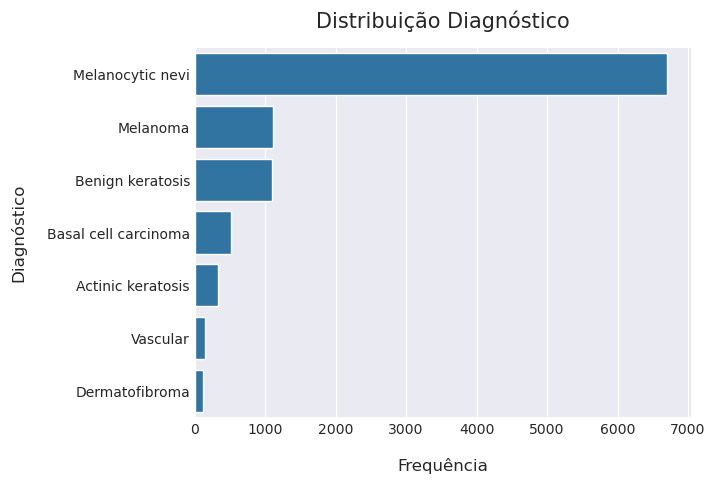

In [ ]:
grafico_barras(dist_alvo, 'n', 'dx', 'Distribuição Diagnóstico', 'Frequência', 'Diagnóstico')

**A distribuição das imagens em consideração ao diagnóstico, variável alvo, é muito irregular.<br>Uma única categoria apresenta 66.95% (n=6705) de todas as observações.<br>Enquanto Melanoma e Benign keratosis apresentam em torno de mil observações (n=1113 e n=1099, respectivamente), de Basal cell carcinoma em diante têm menos representatividade.<br>Por esse motivo, já espera-se dificuldade no desempenho da rede a ser treinada.**

**Considerando que a variável alvo original apresenta um desbalanceamento tão severo, criaremos uma segunda variável alvo com a Criação de uma variável binária informando câncer ou não câncer**

In [ ]:
dicionario_alvo = {
    'akiec':'cancer',
    'bcc':'cancer',
    'bkl':'not cancer',
    'df':'not cancer',
    'mel':'cancer',
    'nv':'not cancer',
    'vasc':'not cancer',
}

metadados['cancer'] = metadados.dx.map(dicionario_alvo)
metadados.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset      cancer  
0  vidir_modern  not cancer  
1  vidir_modern  not cancer  
2  vidir_modern  not cancer  
3  vidir_modern  not cancer  
4  vidir_modern  not cancer

In [ ]:
# verificar a distribuição da variável alvo
dist_alvo_02 = gerar_tabela_categorica(metadados, 'cancer')
dist_alvo_02

cancer     n     n%
0  not cancer  8061  80.49
1      cancer  1954  19.51

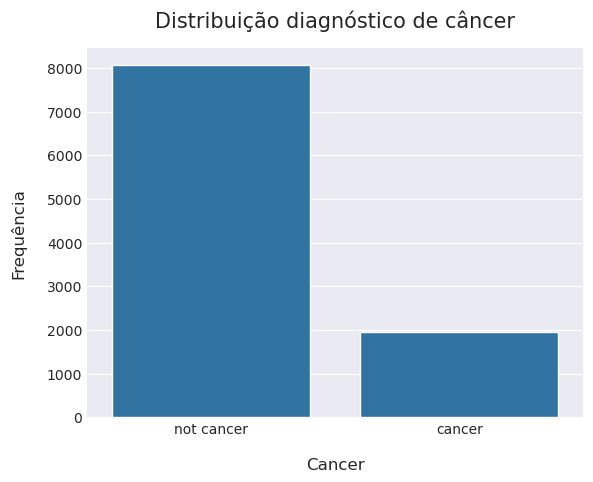

In [ ]:
grafico_colunas(dist_alvo_02, 'cancer', 'n', 'Distribuição diagnóstico de câncer', 'Cancer', 'Frequência')

**Podemos observar que o desequilibrio entre as classes ainda é muito grande. A quantidade de doenças de pele que não são câncer é muito maior.**

#### 2.1.2 Distribuição sexo

In [ ]:
dist_sex = gerar_tabela_categorica(metadados, 'sex')
dist_sex

sex     n     n%
0     male  5406  53.98
1   female  4552  45.45
2  unknown    57   0.57

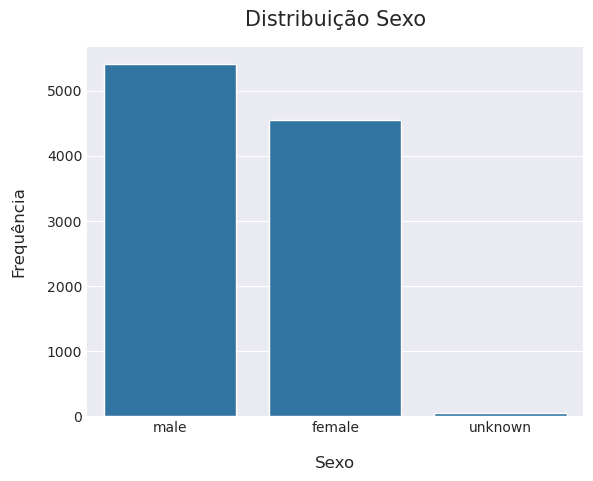

In [ ]:
grafico_colunas(dist_sex, 'sex', 'n', 'Distribuição Sexo', 'Sexo', 'Frequência')

**A distribuição em relação ao sexo é equilibrada**

#### 2.1.3 Distribuição localização

In [ ]:
dist_loc = gerar_tabela_categorica(metadados, 'localization')
dist_loc

localization     n     n%
0              back  2192  21.89
1   lower extremity  2077  20.74
2             trunk  1404  14.02
3   upper extremity  1118  11.16
4           abdomen  1022  10.20
5              face   745   7.44
6             chest   407   4.06
7              foot   319   3.19
8           unknown   234   2.34
9              neck   168   1.68
10            scalp   128   1.28
11             hand    90   0.90
12              ear    56   0.56
13          genital    48   0.48
14            acral     7   0.07

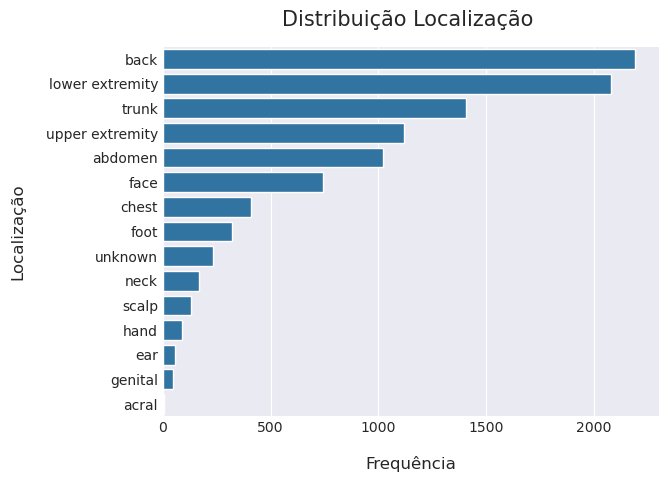

In [ ]:
grafico_barras(dist_loc, 'n', 'localization', 'Distribuição Localização ', 'Frequência', 'Localização')

**A localização da lesão apresenta uma grande variedade de classes (15), mesmo não sendo uma distribuição homogênea, é um resultado intuitivo porque grandes partes do corpo apresentam maior prevalência das lesões.**

#### 2.1.4 Distribuição datasets

**O dataset utilizado neste estudo é uma compilação de 4 datasets menores, conforme distribuição apresentada.**

In [ ]:
dist_dataset = gerar_tabela_categorica(metadados, 'dataset')
dist_dataset

dataset     n     n%
0  vidir_molemax  3954  39.48
1   vidir_modern  3363  33.58
2      rosendahl  2259  22.56
3    vienna_dias   439   4.38

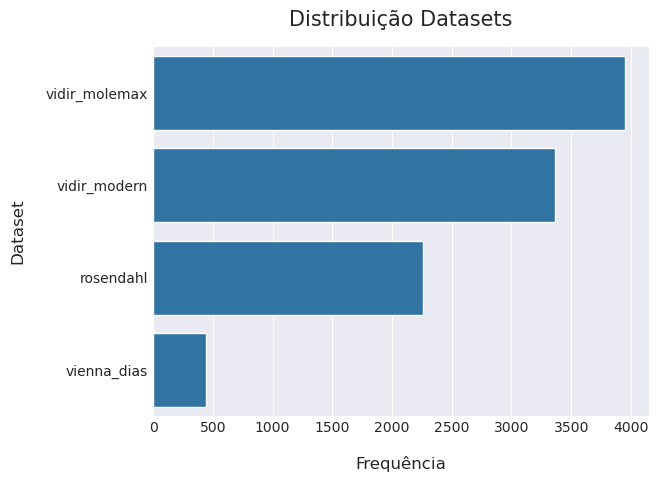

In [ ]:
grafico_barras(dist_dataset, 'n', 'dataset', 'Distribuição Datasets', 'Frequência', 'Dataset')

#### 2.1.5 Distribuição da obtenção do diagnótico

In [ ]:
dist_dx_type = gerar_tabela_categorica(metadados, 'dx_type')
dist_dx_type

dx_type     n     n%
0      histo  5340  53.32
1  follow_up  3704  36.98
2  consensus   902   9.01
3   confocal    69   0.69

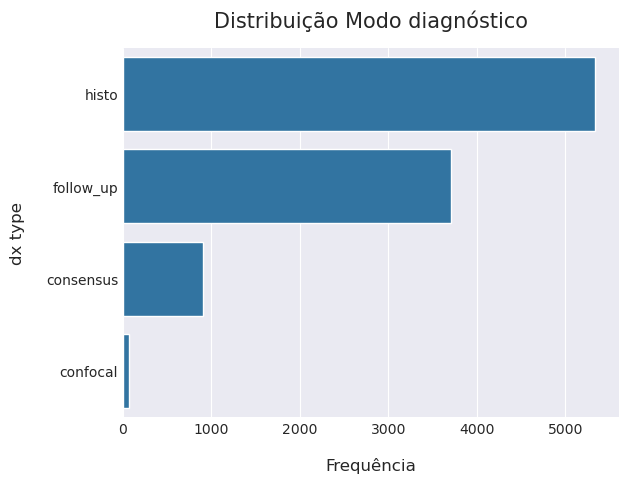

In [ ]:
grafico_barras(dist_dx_type, 'n', 'dx_type', 'Distribuição Modo diagnóstico', 'Frequência', 'dx type')

#### 2.1.6 Estatística descritiva - variáveis numéricas

In [ ]:
metadados.age.describe().round(2)

count    9958.00
mean       51.86
std        16.97
min         0.00
25%        40.00
50%        50.00
75%        65.00
max        85.00
Name: age, dtype: float64

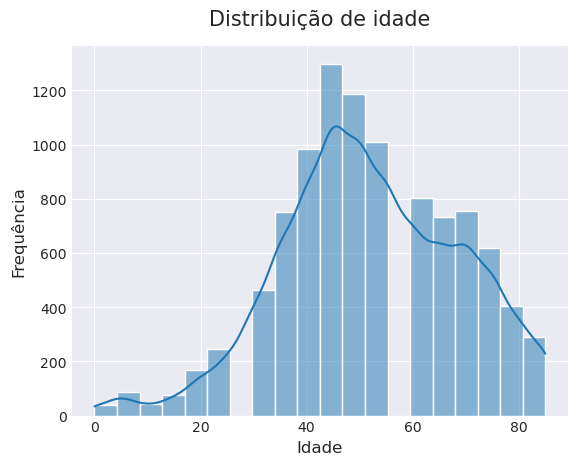

In [ ]:
sns.histplot(metadados.age, bins=20, kde=True)
plt.title('Distribuição de idade', fontsize=15, pad=15)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

### 2.2 Relações e achados

In [ ]:
metadados.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset      cancer  
0  vidir_modern  not cancer  
1  vidir_modern  not cancer  
2  vidir_modern  not cancer  
3  vidir_modern  not cancer  
4  vidir_modern  not cancer

**Tentativa de observação de alguma ligação entre variáveis e a variável alvo.**

In [ ]:
# observar a distribuição das variáveis alvo em relação ao sexo
diagnostico_por_sexo = metadados.groupby(['dx', 'sex']).size()
diagnostico_por_sexo =diagnostico_por_sexo.unstack().reset_index().drop(columns='unknown')
diagnostico_por_sexo['% female'] = (diagnostico_por_sexo.female / diagnostico_por_sexo.female.sum()) *100
diagnostico_por_sexo['% male'] = (diagnostico_por_sexo.male / diagnostico_por_sexo.male.sum()) * 100
diagnostico_por_sexo

sex     dx  female    male   % female     % male
0    akiec   106.0   221.0   2.328647   4.088050
1      bcc   197.0   317.0   4.327768   5.863855
2      bkl   463.0   626.0  10.171353  11.579726
3       df    52.0    63.0   1.142355   1.165372
4      mel   424.0   689.0   9.314587  12.745098
5       nv  3237.0  3421.0  71.111599  63.281539
6     vasc    73.0    69.0   1.603691   1.276360

In [ ]:
diagnostico_por_sexo.sort_values(by='male', ascending=False)

sex     dx  female    male   % female     % male
5       nv  3237.0  3421.0  71.111599  63.281539
4      mel   424.0   689.0   9.314587  12.745098
2      bkl   463.0   626.0  10.171353  11.579726
1      bcc   197.0   317.0   4.327768   5.863855
0    akiec   106.0   221.0   2.328647   4.088050
6     vasc    73.0    69.0   1.603691   1.276360
3       df    52.0    63.0   1.142355   1.165372

**A ordem de distribuição das doenças são as mesmas se considerar os sexos separadamente ou junto.**

**Tentativa de observação da distribuição das classes da variável diagnóstico em relação a idade.**

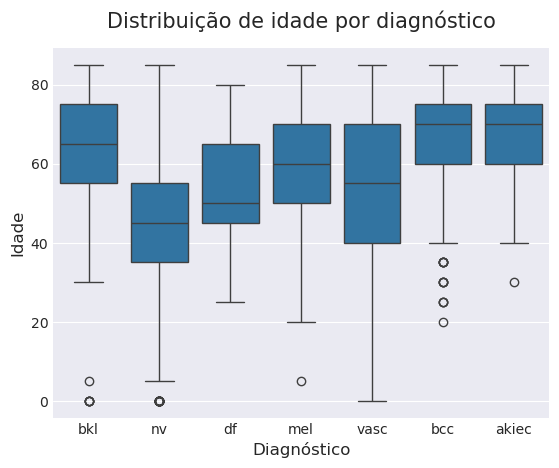

In [ ]:
sns.boxplot(x='dx', y='age', data=metadados)
plt.title('Distribuição de idade por diagnóstico', fontsize=15, pad=15)
plt.xlabel('Diagnóstico', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.show()

**Considerando a mediana, Pode-se observar que a idade do diagnóstico 'nv' é menor em relação aos demais.<br>A amplitude de idade da 'vasc' é a total das observações.**

In [ ]:
diagnostico_por_local_lesao = metadados.groupby(['dx', 'localization']).size()
diagnostico_por_local_lesao = diagnostico_por_local_lesao.unstack()
diagnostico_por_local_lesao = diagnostico_por_local_lesao.replace(np.nan, 0)
diagnostico_por_local_lesao = diagnostico_por_local_lesao.astype(int)
diagnostico_por_local_lesao = diagnostico_por_local_lesao.reset_index().drop(columns='unknown')
diagnostico_por_local_lesao

localization     dx  abdomen  acral  back  chest  ear  face  foot  genital  \
0             akiec        5      0    29     12    3   113     0        0   
1               bcc       18      0   186     47    0   101     4        0   
2               bkl       42      0   202     74    6   319     1        2   
3                df        4      0     2      0    0     0     2        1   
4               mel       66      0   324     68   17   104    28        0   
5                nv      860      7  1427    200   30   100   284       45   
6              vasc       27      0    22      6    0     8     0        0   

localization  hand  lower extremity  neck  scalp  trunk  upper extremity  
0               13               65    10     14      1               62  
1                2               58    14     19     11               49  
2               14              174    31     34     73              104  
3                0               82     0      0      0               24  
4                1              192    29     14     47              213  
5               55             1479    81     45   1241              655  
6                5               27     3      2     31               11

#### 2.2.1 Relações com a variável binária

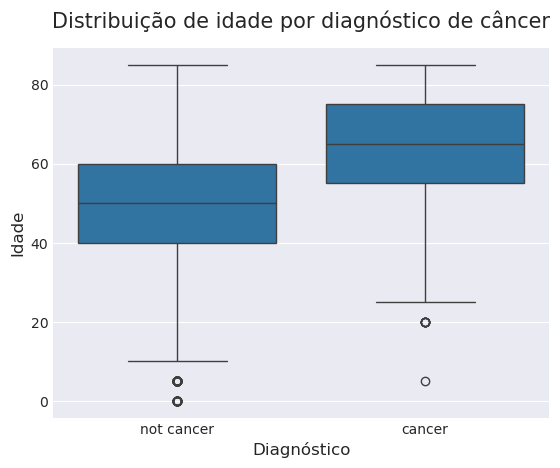

In [ ]:
sns.boxplot(x='cancer', y='age', data=metadados)
plt.title('Distribuição de idade por diagnóstico de câncer', fontsize=15, pad=15)
plt.xlabel('Diagnóstico', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.show()

In [ ]:
cancer_por_sexo = metadados.groupby(['cancer', 'sex']).size()
cancer_por_sexo = cancer_por_sexo.unstack()
cancer_por_sexo = cancer_por_sexo.replace(np.nan, 0)
cancer_por_sexo = cancer_por_sexo.reset_index()
cancer_por_sexo['f%'] = cancer_por_sexo.female / cancer_por_sexo.female.sum()
cancer_por_sexo['m%'] = cancer_por_sexo.male / cancer_por_sexo.male.sum()
cancer_por_sexo

sex      cancer  female    male  unknown       f%       m%
0        cancer   727.0  1227.0      0.0  0.15971  0.22697
1    not cancer  3825.0  4179.0     57.0  0.84029  0.77303

## 3. Importação imagens e avaliação inicial

In [ ]:
# usar o nome de cada imagem para vincular ao dataframe metadados usando a coluna image_id
metadados['image_id'] = metadados['image_id'].apply(lambda x: x + '.jpg')
metadados.head()

lesion_id          image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419.jpg  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030.jpg  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769.jpg  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661.jpg  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633.jpg  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern

In [ ]:
# import zipfile
# from zipfile import ZipFile

# caminho_imagens = '/content/drive/MyDrive/Mestrado/04 - Aprendizagem Profunda/Trabalho/Dados/HAM10000_images.zip'

# with ZipFile(caminho_imagens, 'r') as zip:
#   zip.extractall()

In [ ]:
pasta_imagens = 'dados/HAM10000_images/'
# pasta_imagens = '/content/HAM10000_images/'
lista_arquivos=os.listdir(pasta_imagens)

altura_imagens, largura_imagens, tamanho_imagem, nome_imagem, caminhos, canais_cor = [], [], [], [], [], []

for arquivo in lista_arquivos:
    caminho_arquivo=os.path.join(pasta_imagens, arquivo)
    caminhos.append(caminho_arquivo)
    nome_imagem.append(str(arquivo))

    #informações imagens
    img_shape = mpimg.imread(caminho_arquivo).shape
    altura_imagens.append(img_shape[0])
    largura_imagens.append(img_shape[1])
    canais_cor.append(img_shape[2])
    tamanho_imagem.append(os.path.getsize(caminho_arquivo))

df_imagens = pd.DataFrame(
    {'img_name': nome_imagem,
     'img_height': altura_imagens,
     'img_width': largura_imagens,
     'img_size': tamanho_imagem,
     'color_channels': canais_cor,
     'path': caminhos}
)

df_imagens

img_name  img_height  img_width  img_size  color_channels  \
0      ISIC_0031380.jpg         450        600    242405               3   
1      ISIC_0029113.jpg         450        600    305918               3   
2      ISIC_0034030.jpg         450        600    266379               3   
3      ISIC_0031294.jpg         450        600    162896               3   
4      ISIC_0033721.jpg         450        600    237162               3   
...                 ...         ...        ...       ...             ...   
10010  ISIC_0030523.jpg         450        600    356589               3   
10011  ISIC_0033611.jpg         450        600    290944               3   
10012  ISIC_0028030.jpg         450        600    343542               3   
10013  ISIC_0025919.jpg         450        600    291870               3   
10014  ISIC_0024545.jpg         450        600    341011               3   

                                         path  
0      dados/HAM10000_images/ISIC_0031380.jpg  
1      dados/HAM10000_images/ISIC_0029113.jpg  
2      dados/HAM10000_images/ISIC_0034030.jpg  
3      dados/HAM10000_images/ISIC_0031294.jpg  
4      dados/HAM10000_images/ISIC_0033721.jpg  
...                                       ...  
10010  dados/HAM10000_images/ISIC_0030523.jpg  
10011  dados/HAM10000_images/ISIC_0033611.jpg  
10012  dados/HAM10000_images/ISIC_0028030.jpg  
10013  dados/HAM10000_images/ISIC_0025919.jpg  
10014  dados/HAM10000_images/ISIC_0024545.jpg  

[10015 rows x 6 columns]

In [ ]:
metadados = pd.merge(metadados, df_imagens, left_on='image_id', right_on='img_name')

In [ ]:
metadados.drop(columns=['img_name'], inplace=True)
metadados.head()

lesion_id          image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419.jpg  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030.jpg  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769.jpg  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661.jpg  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633.jpg  bkl   histo  75.0  male          ear   

        dataset  img_height  img_width  img_size  color_channels  \
0  vidir_modern         450        600    311921               3   
1  vidir_modern         450        600    319112               3   
2  vidir_modern         450        600    301831               3   
3  vidir_modern         450        600    345527               3   
4  vidir_modern         450        600    256275               3   

                                     path  
0  dados/HAM10000_images/ISIC_0027419.jpg  
1  dados/HAM10000_images/ISIC_0025030.jpg  
2  dados/HAM10000_images/ISIC_0026769.jpg  
3  dados/HAM10000_images/ISIC_0025661.jpg  
4  dados/HAM10000_images/ISIC_0031633.jpg

In [ ]:
metadados[['img_height', 'img_width', 'img_size', 'color_channels']].describe()

img_height  img_width       img_size  color_channels
count     10015.0    10015.0   10015.000000         10015.0
mean        450.0      600.0  276606.645931             3.0
std           0.0        0.0   45868.880103             0.0
min         450.0      600.0   85332.000000             3.0
25%         450.0      600.0  257209.000000             3.0
50%         450.0      600.0  276916.000000             3.0
75%         450.0      600.0  301120.000000             3.0
max         450.0      600.0  490776.000000             3.0

**A curadoria do dataset deve ser destacada quanto à homogeneidade das imagens.<br>Todas as imagens apresentam 3 canais de cores, com a mesma altura e largura.**

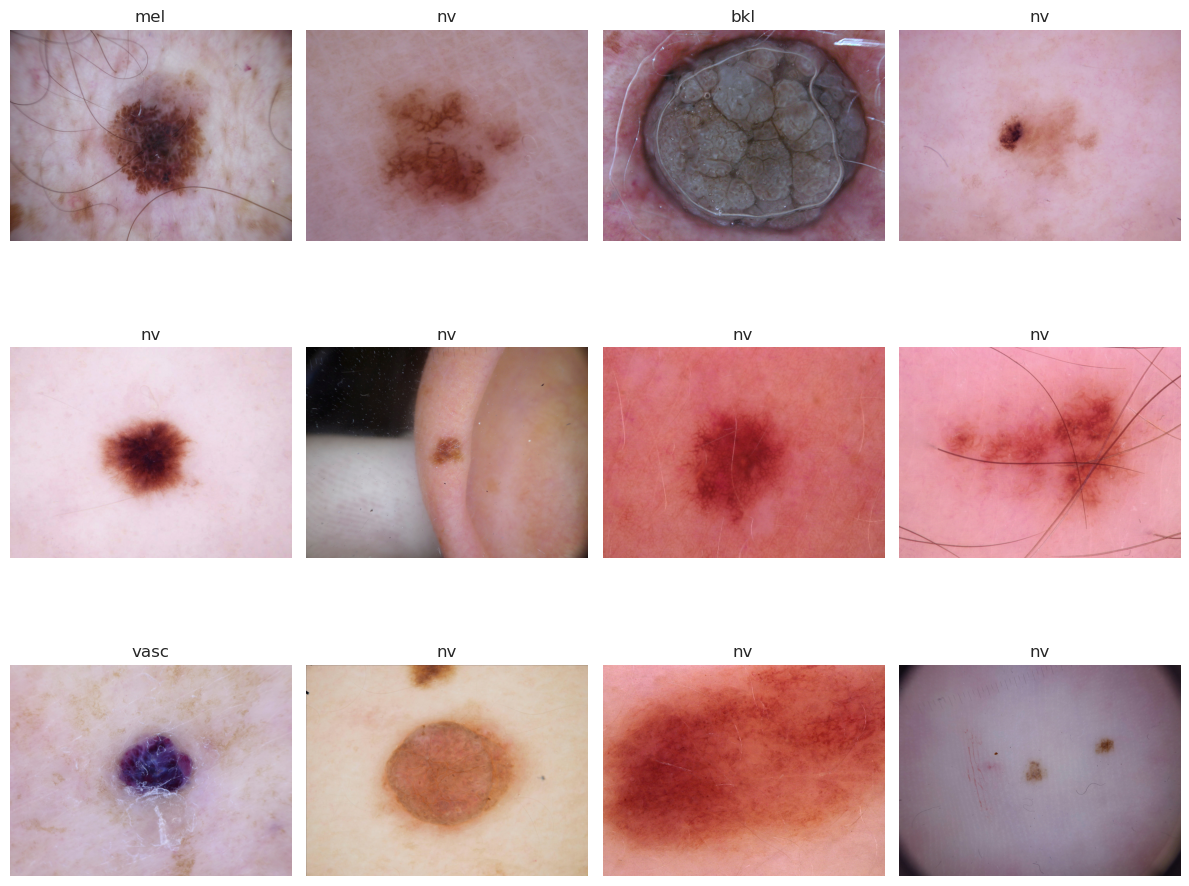

In [ ]:
# Visualizando apenas 12 imagens aleatórias para ter noção de como as imgens são e como são as lesões
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

#sorteio de 12 iamgens
sample = metadados.sample(n=12, random_state=SEED)

for i in range(12):
    subplot = plt.subplot(3, 4, i + 1)

    img_path = sample['path'].iloc[i]

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(sample['dx'].iloc[i])

    plt.tight_layout()

## 4. Separação de dados de treino, teste e validação

**Inicialmente usaremos os dados desbalanceados, para observar até que ponto pode prejudicar a generalização.**

In [ ]:
#separação de treino e teste
train, test_set = train_test_split(metadados, test_size=0.2, random_state=SEED, stratify=metadados.dx)

# com os dados de treino, separar em treino e validação
train_set, val_set = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train.dx)

In [ ]:
# ver o tamanho dos datasets
print(f'Dados de treino: {train_set.shape[0]}')
print(f'Dados de validação: {val_set.shape[0]}')
print(f'Dados de teste: {test_set.shape[0]}')

Dados de treino: 6409
Dados de validação: 1603
Dados de teste: 2003


## 5. Data augmentation

**Benefícios do uso de Data Augmentation**<br>
1. Aumenta o conjunto de dados: Adiciona mais variedade ao conjunto de dados sem coletar mais dados reais.
2. Melhora a robustez: O modelo aprende a ser robusto a variações comuns, como mudanças de escala (zoom), rotação ou deslocamentos(horizontais e verticais).
3. Reduz Overfitting: Ao apresentar imagens "novas" em cada epoch, o modelo evita memorizar o conjunto de treinamento.

In [ ]:
# única manipulação nas imagens de teste será a normalização
gerador_imagem_teste = keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255)

# manipulação dados de treino com normalização e aumento de imagens com rotação e espelhamento
gerador_imagem_treino = keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255, zoom_range=0.2, rotation_range=90, width_shift_range=0.2,
                                           height_shift_range=0.2, horizontal_flip=True)

In [ ]:
#uso do gerador de imagens com a função de importação de um dataframe
imagens_treino = gerador_imagem_treino.flow_from_dataframe(dataframe= train_set, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                      class_mode="categorical", batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

imagens_validacao = gerador_imagem_teste.flow_from_dataframe(dataframe= val_set, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False)

imagens_teste = gerador_imagem_teste.flow_from_dataframe(dataframe= test_set, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False)

Found 6409 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


**Observação dos efeitos do Data augmentation nas imagens de treinamento**

Found 1 validated image filenames belonging to 1 classes.


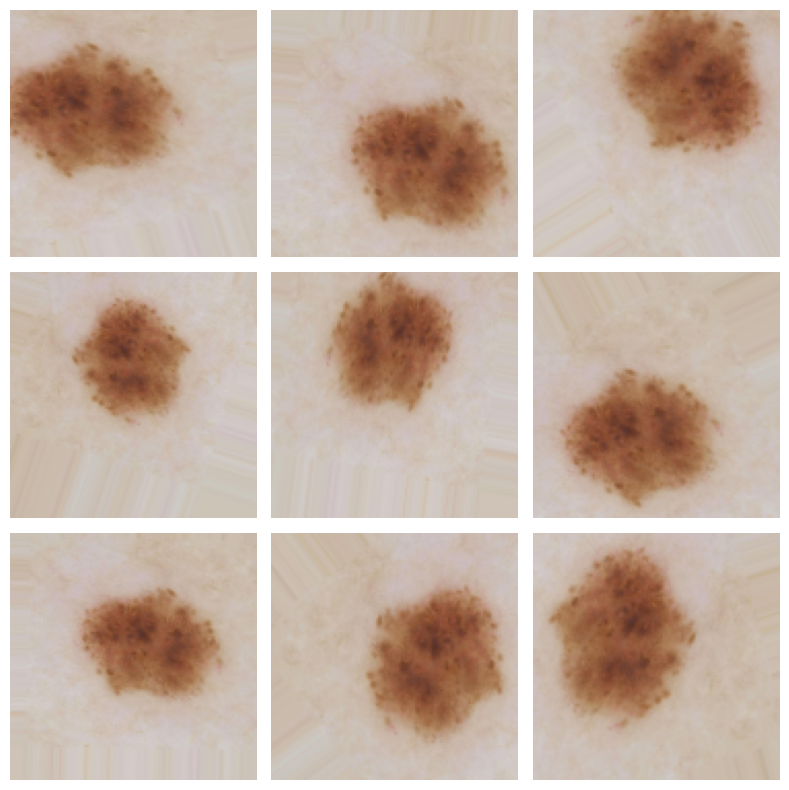

In [ ]:
# Pegando um registro aleatório do conjunto de treino
sample = train_set.sample(n=1, random_state=SEED)

sample_generator = gerador_imagem_treino.flow_from_dataframe(dataframe= sample, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                            class_mode="categorical", batch_size=BATCH_SIZE, color_mode='rgb')

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

**Neste estudo nos prompomos a apresentar algumas configurações de redes, com complexidades variáveis para comparar seu desempenho.**

## 6. Teste preliminar de um modelo

**Criação de callbacs é útil para otimizar o processamento dos modelos de várias formas: Parando o treinamento no caso de não apresentar melhora em uma quantidade determinada de épocas, salvar a melhor configuração de parâmetros durante o treinamento, entre outros.**

**Neste trabalho, usaremos O callback ModelCheckpoint é usado para salvar o modelo em seu melhor desempenho (melhor configuração de parâmetros) durante o treinamento (geralmente baseado na métrica de validação).**

#### 6.1 [A] - Modelo com 1 convolução e 1 camada

In [ ]:
#definição do nome do modelo a ser salvo
checkpoint = limpeza_para_treinamento('best_model_0')

In [ ]:
model_0 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')  # 7 classes -> 7 neurônios na camada de saída
])

I0000 00:00:1734388352.321204     467 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734388352.321314     467 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734388352.321336     467 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734388354.206726     467 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734388354.206830     467 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-16

In [ ]:
model_0.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 445568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    57,032,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,037,319 (217.58 MB)

 Trainable params: 57,037,319 (217.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_0.fit(
    imagens_treino,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao,
    callbacks=[checkpoint])

Epoch 1/50


/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734388357.400633     615 service.cc:146] XLA service 0x7ff708003f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734388357.400681     615 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-12-16 19:32:37.476607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-16 19:32:37.637243: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN

  1/201 ━━━━━━━━━━━━━━━━━━━━ 17:21 5s/step - accuracy: 0.4688 - loss: 1.9050

I0000 00:00:1734388360.092481     615 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6336 - loss: 3.8699
Epoch 1: val_loss improved from inf to 0.95712, saving model to best_model_0.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.6338 - loss: 3.8593 - val_accuracy: 0.6687 - val_loss: 0.9571
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6700 - loss: 0.9855
Epoch 2: val_loss did not improve from 0.95712
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 268ms/step - accuracy: 0.6699 - loss: 0.9855 - val_accuracy: 0.6675 - val_loss: 0.9983
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6634 - loss: 0.9733
Epoch 3: val_loss improved from 0.95712 to 0.91222, saving model to best_model_0.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 274ms/step - accuracy: 0.6634 - loss: 0.9731 - val_accuracy: 0.6712 - val_loss: 0.9122
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6701 - loss: 0.8965
Epoch 4: val_loss improved from 0.91222 to 0.90851, saving model to best_model_0.k

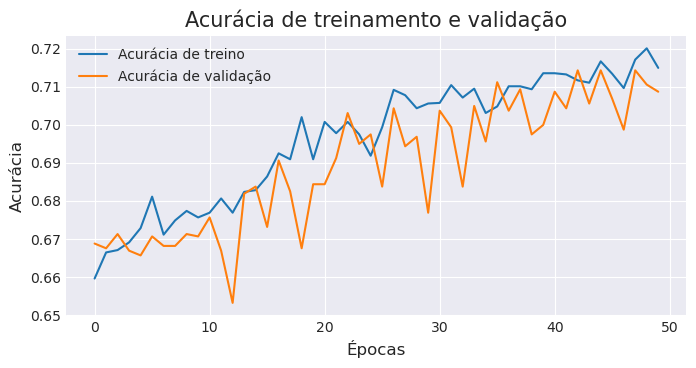

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

**O treinamento, embora ruidoso, progrediu de 0,6 para 0,7. Não há indicação de overfitting (validação e treinamento progredindo juntos)**

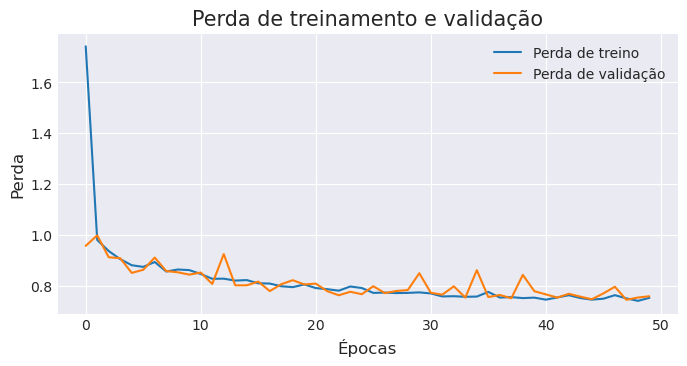

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

**O valor da função de perda de treinamento e validação caminharam juntos estabilizando em 0.7 sem indicação de overfitting.**

In [ ]:
# carregamento do melhor modelo
best_model_01 = keras.models.load_model('best_model_0.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_01.evaluate(imagens_teste, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.7105 - loss: 0.7853
Resultado com dados de teste: accuracy = 0.7174238562583923  ;  loss = 0.7720681428909302


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step


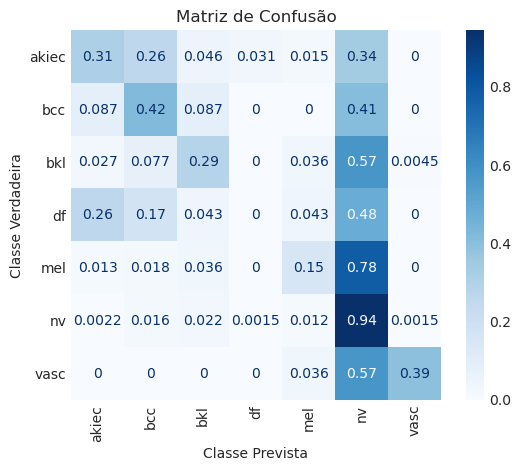

In [ ]:
# previsão no conjunto de teste
predictions = best_model_01.predict(imagens_teste)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste.classes

# criar matriz de confusão
matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.43      0.31      0.36        65
           1       0.40      0.42      0.41       103
           2       0.55      0.29      0.38       220
           3       0.00      0.00      0.00        23
           4       0.56      0.15      0.24       223
           5       0.76      0.94      0.84      1341
           6       0.79      0.39      0.52        28

    accuracy                           0.72      2003
   macro avg       0.50      0.36      0.39      2003
weighted avg       0.68      0.72      0.67      2003



**O modelo foi bom para identificar corretamente a classe NV (0,93), mas com muitos falsos positivos.<br>Devemos pontuar que houve uma prevalência para o modelo indicar esse classe.O que demonstra que o desbalanceamento das classes prejudica a generalização.<br>A classe Vasc também foi bem classificada em (0,61).**

### 6.2 [B] - Modelo com 2 convoluções e 1 camada densa

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_01')

In [ ]:
model_01 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')  # 7 classes -> 7 neurônios na camada de saída
])

In [ ]:
model_01.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,500,935 (24.80 MB)

 Trainable params: 6,500,935 (24.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_01.fit(
    imagens_treino,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao,
    callbacks=[checkpoint])

Epoch 1/50
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6349 - loss: 1.2450
Epoch 1: val_loss improved from inf to 1.10192, saving model to best_model_01.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.6351 - loss: 1.2436 - val_accuracy: 0.6694 - val_loss: 1.1019
Epoch 2/50
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6673 - loss: 1.0247
Epoch 2: val_loss improved from 1.10192 to 0.99927, saving model to best_model_01.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 268ms/step - accuracy: 0.6673 - loss: 1.0245 - val_accuracy: 0.6600 - val_loss: 0.9993
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6652 - loss: 0.9967
Epoch 3: val_loss did not improve from 0.99927
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 263ms/step - accuracy: 0.6652 - loss: 0.9966 - val_accuracy: 0.6550 - val_loss: 1.0042
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6638 - loss: 0.9473
Epoch 4: val_loss improved from 0.99927 to 0.92540, saving model to b

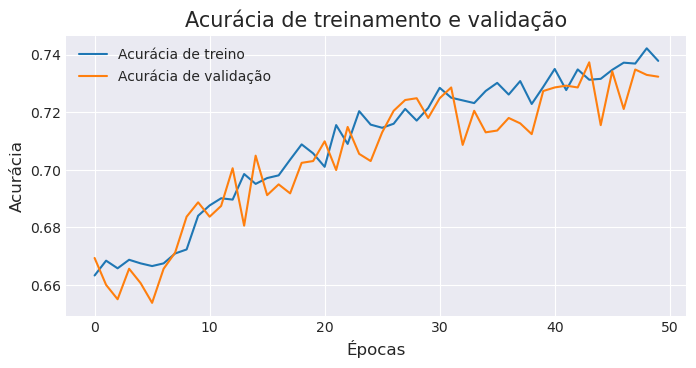

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

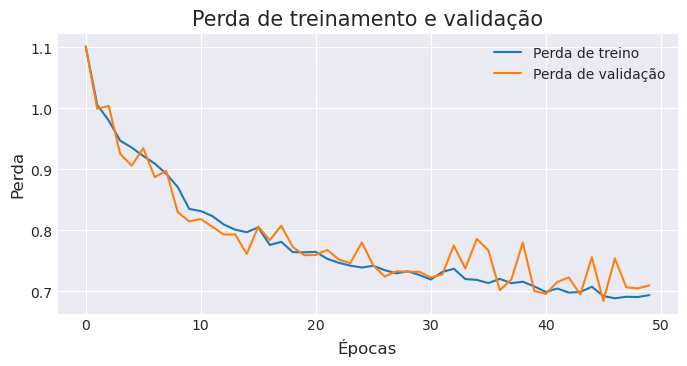

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

**Pelos gráficos percebe-se que as acurácias de validação e treinamento estão subindo consistentemente e juntas.<br>O mesmo pode ser visto no gráfico de perdas.**

In [ ]:
# carregamento do melhor modelo
best_model_01 = keras.models.load_model('best_model_01.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_01.evaluate(imagens_teste, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.7298 - loss: 0.6982
Resultado com dados de teste: accuracy = 0.7348976731300354  ;  loss = 0.695959210395813


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step


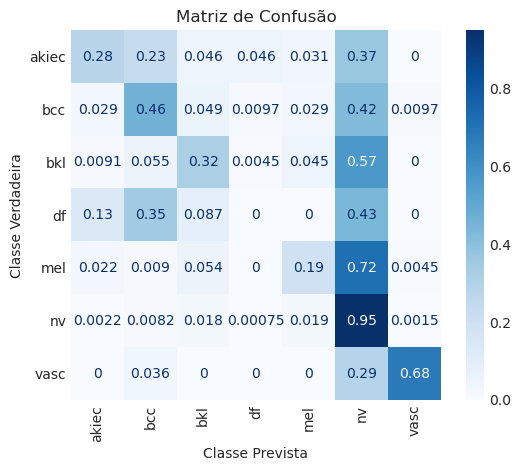

In [ ]:
# previsão no conjunto de teste
predictions = best_model_01.predict(imagens_teste)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.53      0.28      0.36        65
           1       0.49      0.46      0.47       103
           2       0.60      0.32      0.42       220
           3       0.00      0.00      0.00        23
           4       0.52      0.19      0.28       223
           5       0.78      0.95      0.85      1341
           6       0.83      0.68      0.75        28

    accuracy                           0.73      2003
   macro avg       0.53      0.41      0.45      2003
weighted avg       0.70      0.73      0.70      2003



### 6.3 [C] - Modelo com 2 convoluções e 4 camadas densas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_02')

In [ ]:
model_02 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model_02.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_02.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,511,015 (24.84 MB)

 Trainable params: 6,511,015 (24.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_02.fit(
    imagens_treino,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao,
    callbacks=[checkpoint]
)

Epoch 1/50
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6398 - loss: 1.1401
Epoch 1: val_loss improved from inf to 1.01380, saving model to best_model_02.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 60s 284ms/step - accuracy: 0.6401 - loss: 1.1393 - val_accuracy: 0.6681 - val_loss: 1.0138
Epoch 2/50
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6753 - loss: 0.9659
Epoch 2: val_loss improved from 1.01380 to 0.94546, saving model to best_model_02.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.6752 - loss: 0.9660 - val_accuracy: 0.6619 - val_loss: 0.9455
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6676 - loss: 0.9518
Epoch 3: val_loss did not improve from 0.94546
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - accuracy: 0.6676 - loss: 0.9518 - val_accuracy: 0.6694 - val_loss: 0.9545
Epoch 4/50
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6701 - loss: 0.9323
Epoch 4: val_loss improved from 0.94546 to 0.92288, saving model to b

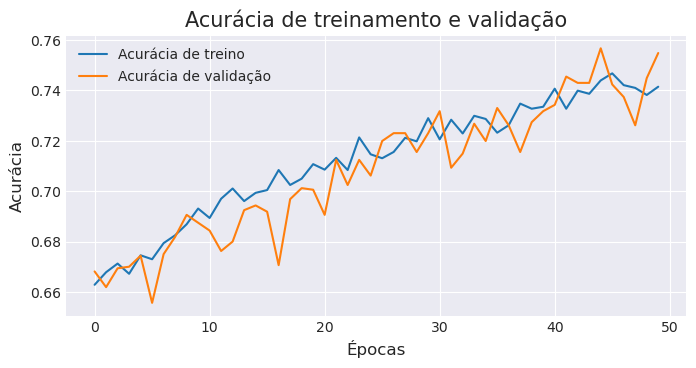

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

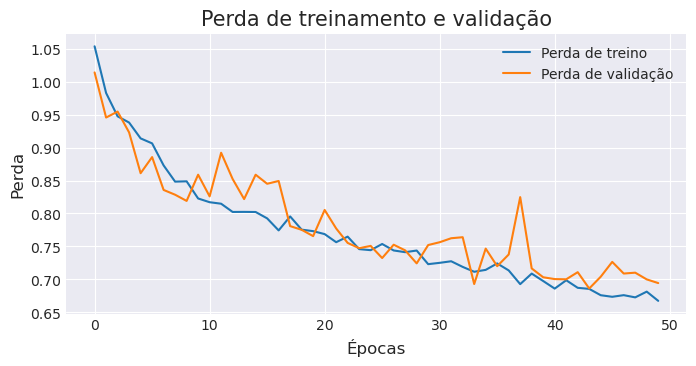

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
best_model_02 = keras.models.load_model('best_model_02.keras')

test_loss, test_acc = best_model_02.evaluate(imagens_teste, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.7379 - loss: 0.7083
Resultado com dados de teste: accuracy = 0.7428856492042542  ;  loss = 0.701605498790741


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step


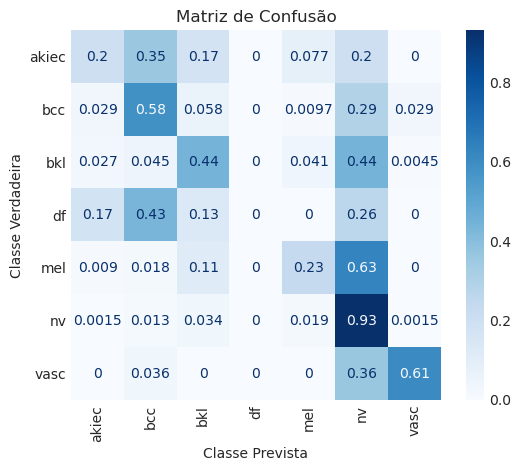

In [ ]:
predictions = best_model_02.predict(imagens_teste)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.43      0.20      0.27        65
           1       0.48      0.58      0.52       103
           2       0.52      0.44      0.48       220
           3       0.00      0.00      0.00        23
           4       0.57      0.23      0.33       223
           5       0.81      0.93      0.87      1341
           6       0.74      0.61      0.67        28

    accuracy                           0.74      2003
   macro avg       0.51      0.43      0.45      2003
weighted avg       0.71      0.74      0.71      2003



/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

**Mesmo adicionando uma camada de convolução para aumentar a capacidade de identificação das características das imagens, mas o desbalanceamento entre as classes ainda prejudica o modelo. A classificação das imagens para a classe nv é forte.<br>Destaque que a classe bcc, bkl e vasc melhoraram a classificação.<br>Destaca-se que a classe vasc tem poucas observações (142) mesmo assim o modelo consegue identificá-lo.**

**Enquanto as classes que possuem uma maior quantidade de amostras possui uma boa acertividade, o mesmo não podemos observar nas classes menos representativas.**

### 6.4 Modelo [C] com mais épocas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_C')

In [ ]:
model_02 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model_02.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_02.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,511,015 (24.84 MB)

 Trainable params: 6,511,015 (24.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_02.fit(
    imagens_treino,
    epochs=100,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao,
    callbacks=[checkpoint]
)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6433 - loss: 1.2026
Epoch 1: val_loss improved from inf to 1.00618, saving model to best_model_C.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 267ms/step - accuracy: 0.6434 - loss: 1.2020 - val_accuracy: 0.6694 - val_loss: 1.0062
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6666 - loss: 1.0117
Epoch 2: val_loss improved from 1.00618 to 0.96503, saving model to best_model_C.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.6667 - loss: 1.0117 - val_accuracy: 0.6700 - val_loss: 0.9650
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6722 - loss: 0.9622
Epoch 3: val_loss improved from 0.96503 to 0.95441, saving model to best_model_C.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step - accuracy: 0.6721 - loss: 0.9622 - val_accuracy: 0.6687 - val_loss: 0.9544
Epoch 4/100
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6624 - loss: 0.9376
Epoch 4: val_loss improved 

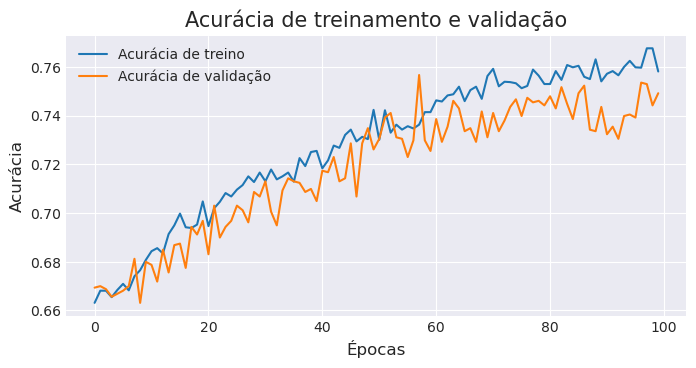

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

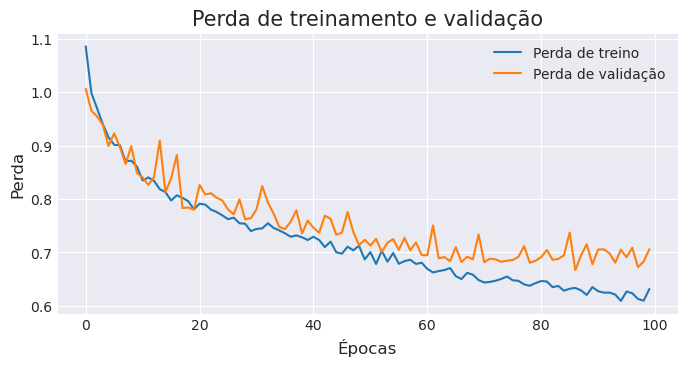

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
best_model_02 = keras.models.load_model('best_model_C.keras')

test_loss, test_acc = best_model_02.evaluate(imagens_teste, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.7506 - loss: 0.6883
Resultado com dados de teste: accuracy = 0.7468796968460083  ;  loss = 0.6947413682937622


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step


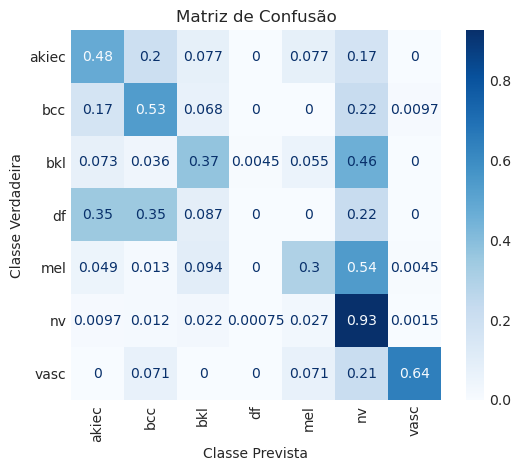

In [ ]:
predictions = best_model_02.predict(imagens_teste)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.32      0.48      0.39        65
           1       0.52      0.53      0.53       103
           2       0.56      0.37      0.45       220
           3       0.00      0.00      0.00        23
           4       0.55      0.30      0.39       223
           5       0.82      0.93      0.87      1341
           6       0.82      0.64      0.72        28

    accuracy                           0.75      2003
   macro avg       0.51      0.46      0.48      2003
weighted avg       0.72      0.75      0.73      2003



### 6.5 Undersampling da classe NV

**A tentativa para melhorar o desempenho do modelo neste trabalho será de undersampling**

In [ ]:
metadados.dx.value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [ ]:
dados_nv = metadados[metadados.dx == 'nv']
dados_not_nv = metadados[metadados.dx != 'nv']

In [ ]:
# fixação do número de exemplos da classe nv igual à camada mel
dados_nv = dados_nv.sample(n=1113, random_state=SEED)

In [ ]:
dados_balanceados = pd.concat([dados_nv, dados_not_nv], ignore_index=True)
dados_balanceados.shape

(4423, 13)

## 7. Nova separação de dados de treino e teste

In [ ]:
#separação de treino e teste
train, test_set = train_test_split(dados_balanceados, test_size=0.2, random_state=SEED, stratify=dados_balanceados.dx)

# com os dados de treino, separar em treino e validação
train_set, val_set = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train.dx)

# ver o tamanho dos datasets
print(f'Dados de treino: {train_set.shape[0]}')
print(f'Dados de validação: {val_set.shape[0]}')
print(f'Dados de teste: {test_set.shape[0]}')

Dados de treino: 2830
Dados de validação: 708
Dados de teste: 885


In [ ]:
#uso do gerador de imagens com a função de importação de um dataframe
imagens_treino_under = gerador_imagem_treino.flow_from_dataframe(dataframe= train_set, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                      class_mode="categorical", batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

imagens_validacao_under = gerador_imagem_teste.flow_from_dataframe(dataframe= val_set, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False)

imagens_teste_under = gerador_imagem_teste.flow_from_dataframe(dataframe= test_set, x_col="path", y_col="dx", target_size=IMAGE_SIZE,
                                                    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False)

Found 2830 validated image filenames belonging to 7 classes.
Found 708 validated image filenames belonging to 7 classes.
Found 885 validated image filenames belonging to 7 classes.


#### 7.1 [A] - Modelo com 1 camada de convolução e 1 camada densa

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_0')

In [ ]:
model_0 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')  # 7 classes -> 7 neurônios na camada de saída
])

In [ ]:
model_0.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 445568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    57,032,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,037,319 (217.58 MB)

 Trainable params: 57,037,319 (217.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_0.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50


/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3083 - loss: 8.1212
Epoch 1: val_loss improved from inf to 1.49559, saving model to best_model_0.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 348ms/step - accuracy: 0.3088 - loss: 8.0695 - val_accuracy: 0.4308 - val_loss: 1.4956
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.4194 - loss: 1.4921
Epoch 2: val_loss did not improve from 1.49559
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.4195 - loss: 1.4919 - val_accuracy: 0.4534 - val_loss: 1.5016
Epoch 3/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4295 - loss: 1.4831
Epoch 3: val_loss improved from 1.49559 to 1.43655, saving model to best_model_0.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.4298 - loss: 1.4821 - val_accuracy: 0.4590 - val_loss: 1.4366
Epoch 4/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4552 - loss: 1.3927
Epoch 4: val_loss improved from 1.43655 to 1.38536, saving model to best_model_0.keras
89/89 ━━━

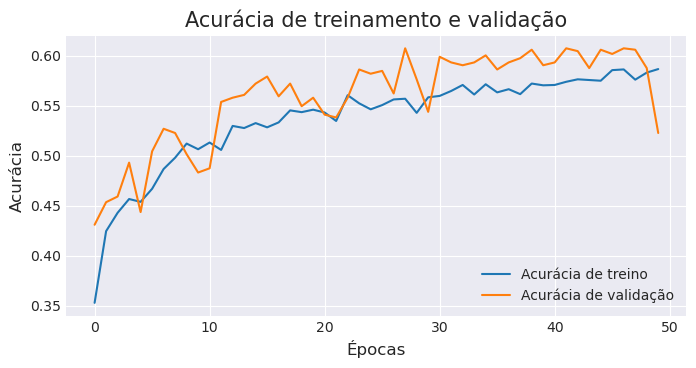

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

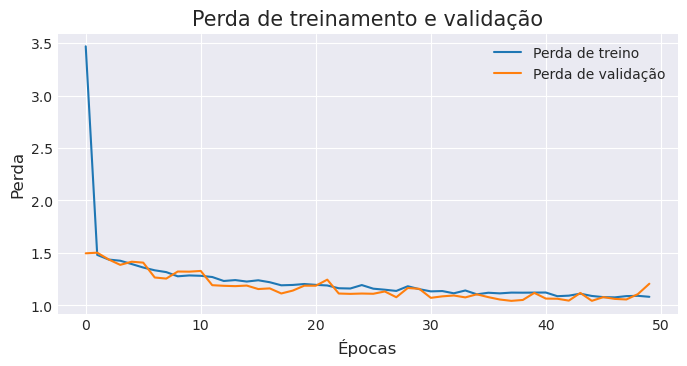

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_0 = keras.models.load_model('best_model_0.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_0.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.6132 - loss: 1.0198
Resultado com dados de teste: accuracy = 0.594350278377533  ;  loss = 1.060567855834961


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step


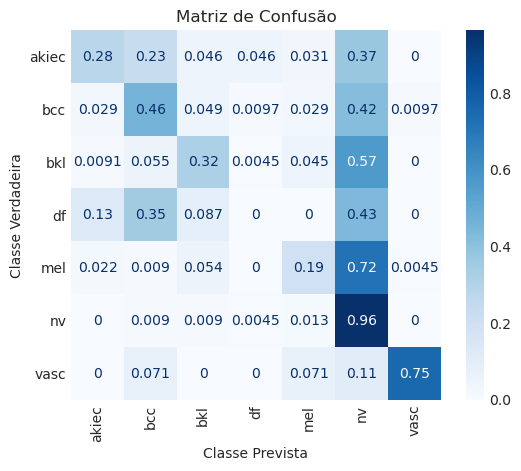

In [ ]:
# previsão no conjunto de teste
predictions = best_model_01.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.58      0.28      0.38        65
           1       0.53      0.46      0.49       103
           2       0.74      0.32      0.45       220
           3       0.00      0.00      0.00        23
           4       0.68      0.19      0.30       223
           5       0.37      0.96      0.54       223
           6       0.91      0.75      0.82        28

    accuracy                           0.47       885
   macro avg       0.55      0.42      0.42       885
weighted avg       0.58      0.47      0.43       885



**Com a redução da diferença entre a classe mais predominante com relação à segunda melhorou o desempenho do modelo.<br>Mesmo que a acurácia tenha diminuído, mas outras métricas (recall e precisão) melhoraram.**

### 7.2 [B] - Modelo com 2 convoluções e 1 camada densa - nova tentativa

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_01')

In [ ]:
# definição do modelo
model_01 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),

    keras.layers.Dense(7, activation='softmax')
])

## compilação
model_01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,500,935 (24.80 MB)

 Trainable params: 6,500,935 (24.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## treinamento
history = model_01.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2955 - loss: 1.7891
Epoch 1: val_loss improved from inf to 1.53309, saving model to best_model_01.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.2959 - loss: 1.7878 - val_accuracy: 0.3969 - val_loss: 1.5331
Epoch 2/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4075 - loss: 1.5042
Epoch 2: val_loss improved from 1.53309 to 1.45516, saving model to best_model_01.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.4077 - loss: 1.5044 - val_accuracy: 0.4421 - val_loss: 1.4552
Epoch 3/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4227 - loss: 1.4988
Epoch 3: val_loss improved from 1.45516 to 1.43335, saving model to best_model_01.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.4230 - loss: 1.4982 - val_accuracy: 0.4322 - val_loss: 1.4333
Epoch 4/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4629 - loss: 1.4480
Epoch 4: val_loss improved from 1.43335 to

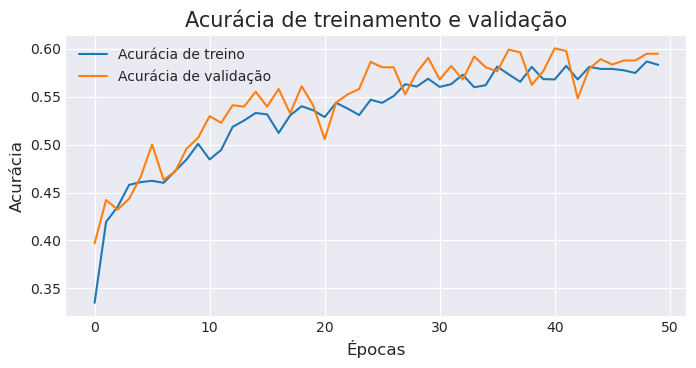

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

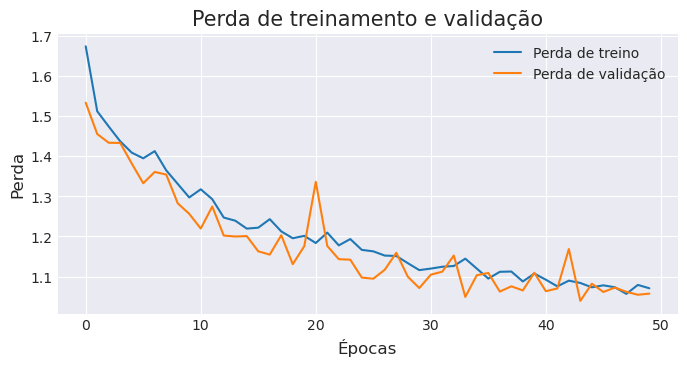

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_01 = keras.models.load_model('best_model_01.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_01.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5839 - loss: 1.0395
Resultado com dados de teste: accuracy = 0.5694915056228638  ;  loss = 1.0922049283981323


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step


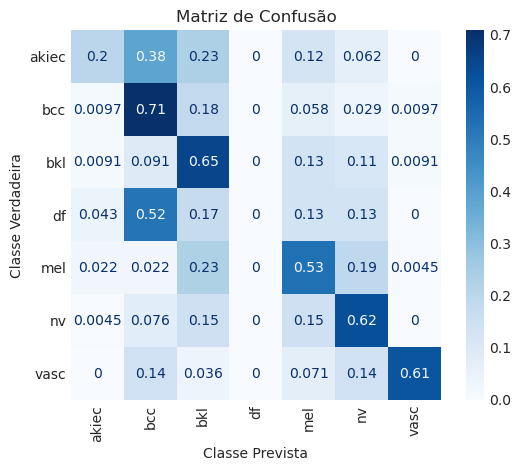

In [ ]:
# previsão no conjunto de teste
predictions = best_model_01.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

**A classe df ainda é um desafio para ser identificada. Dentre os desafios está a quantidade de exemplos para o treinamento.**

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.57      0.20      0.30        65
           1       0.47      0.71      0.56       103
           2       0.54      0.65      0.59       220
           3       0.00      0.00      0.00        23
           4       0.59      0.53      0.56       223
           5       0.63      0.62      0.63       223
           6       0.81      0.61      0.69        28

    accuracy                           0.57       885
   macro avg       0.52      0.47      0.48       885
weighted avg       0.57      0.57      0.56       885



/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

As métricas melhoraram no geral, mas com valores ainda ruins para uma realidade de saúde

### 7.3 [C] - Modelo com 2 convoluções e 1 camada densa (número de filtros invertidos)

**Tentativa de observar se faz diferença a ordem do múmero de filtros na camada convolucional**

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_01_mod')

In [ ]:
# definição do modelo
model_01_mod = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),

    keras.layers.Dense(7, activation='softmax')
])

## compilação
model_01_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_01_mod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,921,735 (49.29 MB)

 Trainable params: 12,921,735 (49.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## treinamento
history = model_01_mod.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2373 - loss: 2.5002
Epoch 1: val_loss improved from inf to 1.61385, saving model to best_model_01_mod.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 277ms/step - accuracy: 0.2380 - loss: 2.4875 - val_accuracy: 0.3658 - val_loss: 1.6138
Epoch 2/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3515 - loss: 1.5914
Epoch 2: val_loss improved from 1.61385 to 1.47658, saving model to best_model_01_mod.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.3522 - loss: 1.5909 - val_accuracy: 0.4096 - val_loss: 1.4766
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.4418 - loss: 1.4713
Epoch 3: val_loss improved from 1.47658 to 1.39790, saving model to best_model_01_mod.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.4418 - loss: 1.4712 - val_accuracy: 0.4647 - val_loss: 1.3979
Epoch 4/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4245 - loss: 1.4736
Epoch 4: val_loss did not impr

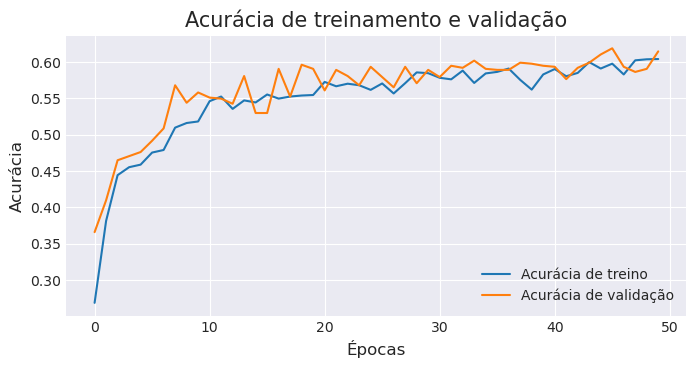

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

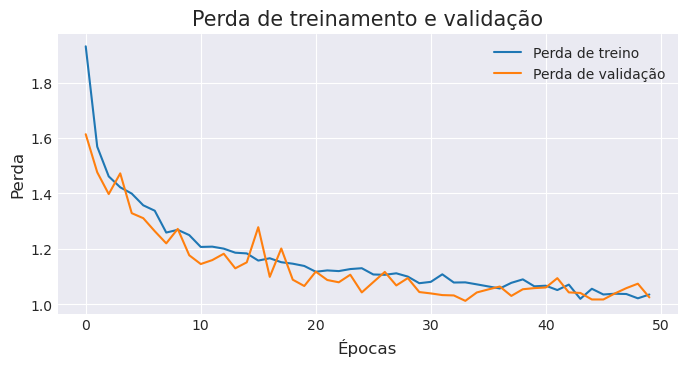

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_01_mod = keras.models.load_model('best_model_01_mod.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_01_mod.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.6065 - loss: 1.0111
Resultado com dados de teste: accuracy = 0.6033898591995239  ;  loss = 1.0414665937423706


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step


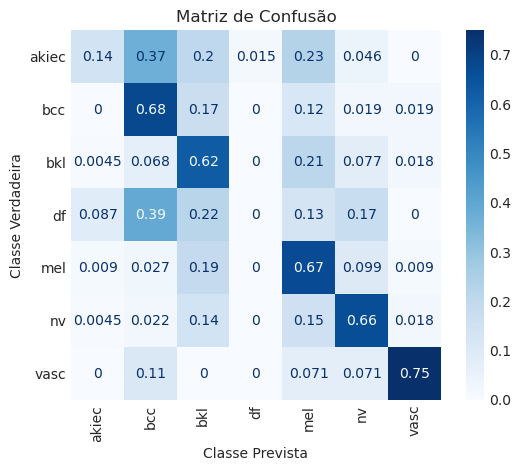

In [ ]:
# previsão no conjunto de teste
predictions = best_model_01_mod.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.60      0.14      0.23        65
           1       0.53      0.68      0.60       103
           2       0.56      0.62      0.59       220
           3       0.00      0.00      0.00        23
           4       0.57      0.67      0.62       223
           5       0.75      0.66      0.70       223
           6       0.64      0.75      0.69        28

    accuracy                           0.60       885
   macro avg       0.52      0.50      0.49       885
weighted avg       0.60      0.60      0.59       885



**A troca da ordem entre as convoluções não trouxe diferença no resultado, embora na 2ª configuração tenha metade dos parâmetros totais.**

### 7.4 [D] - Modelo com 2 convoluções e 4 camadas densas

Observação do comportamento do aumento gradual de profundidade da rede com aumento de camadas ocultas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_02')

In [ ]:
model_02 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model_02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_02.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,511,015 (24.84 MB)

 Trainable params: 6,511,015 (24.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_02.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50


/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734431745.037712    1329 service.cc:146] XLA service 0x7f4f18002310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734431745.037775    1329 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-12-17 07:35:45.129356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 07:35:45.358449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN

 1/89 ━━━━━━━━━━━━━━━━━━━━ 11:15 8s/step - accuracy: 0.1250 - loss: 1.9459

I0000 00:00:1734431750.252956    1329 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.2425 - loss: 1.8099
Epoch 1: val_loss improved from inf to 1.62294, saving model to best_model_02.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 308ms/step - accuracy: 0.2427 - loss: 1.8086 - val_accuracy: 0.2952 - val_loss: 1.6229
Epoch 2/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3426 - loss: 1.6048
Epoch 2: val_loss improved from 1.62294 to 1.48856, saving model to best_model_02.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.3434 - loss: 1.6038 - val_accuracy: 0.4421 - val_loss: 1.4886
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4424 - loss: 1.4879
Epoch 3: val_loss improved from 1.48856 to 1.41662, saving model to best_model_02.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.4424 - loss: 1.4876 - val_accuracy: 0.4760 - val_loss: 1.4166
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4247 - loss: 1.4741
Epoch 4: val_loss did not improve from 1.41662
89/89 

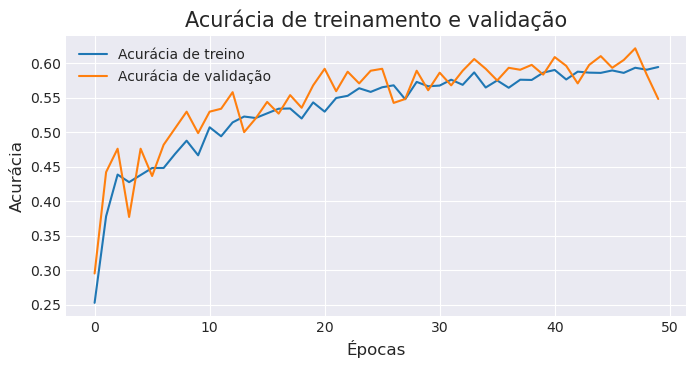

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

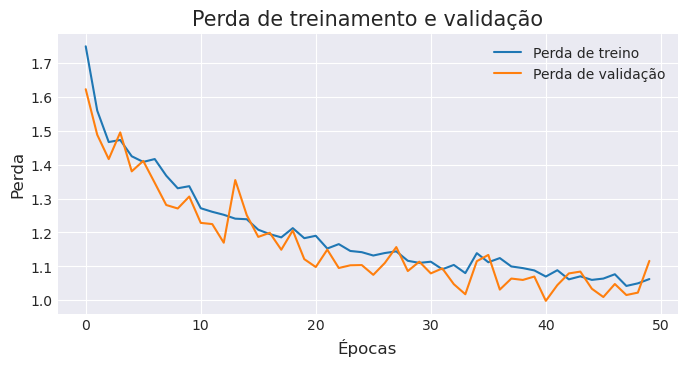

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_02 = keras.models.load_model('best_model_02.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_02.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.5837 - loss: 1.0309
Resultado com dados de teste: accuracy = 0.5717514157295227  ;  loss = 1.071612000465393


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step


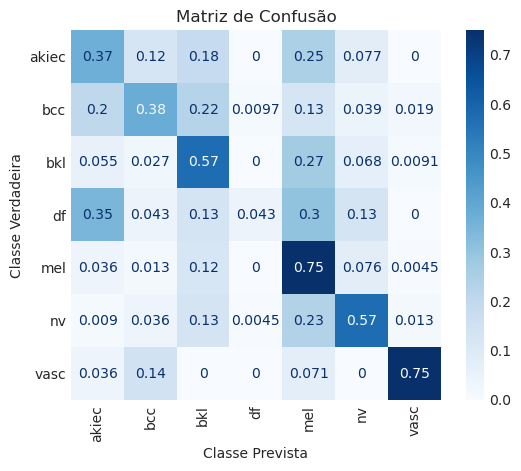

In [ ]:
# previsão no conjunto de teste
predictions = best_model_02.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.32      0.37      0.34        65
           1       0.57      0.38      0.45       103
           2       0.57      0.57      0.57       220
           3       0.33      0.04      0.08        23
           4       0.53      0.75      0.62       223
           5       0.74      0.57      0.65       223
           6       0.72      0.75      0.74        28

    accuracy                           0.57       885
   macro avg       0.54      0.49      0.49       885
weighted avg       0.58      0.57      0.56       885



O resultado deste modelo é praticamente o mesmo do anterior. Destacando que até agora, a classe 3 não apresenta acertos.

Considera-se pior que o primeiro modelo se levar em consideração os valores de precisão.

### 7.5 [E] - Modelo com 4 convoluções e 4 camadas densas

Todas as convoluções com a mesma configuração de kernel de de filtros

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_03')

In [ ]:
model_03 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_03.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,231 (1.27 MB)

 Trainable params: 332,231 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_03.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50
63/89 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.2422 - loss: 1.7895

2024-12-17 07:56:42.487321: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=0,k3=0} for conv (f32[14,64,59,59]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,64,57,57]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-12-17 07:56:42.492153: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.135162742s
Trying algorithm eng2{k2=0,k3=0} for conv (f32[14,64,59,59]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,64,57,57]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queue

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2460 - loss: 1.7761
Epoch 1: val_loss improved from inf to 1.73120, saving model to best_model_03.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 295ms/step - accuracy: 0.2461 - loss: 1.7751 - val_accuracy: 0.2528 - val_loss: 1.7312
Epoch 2/50
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2533 - loss: 1.6847
Epoch 2: val_loss improved from 1.73120 to 1.61197, saving model to best_model_03.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.2539 - loss: 1.6837 - val_accuracy: 0.2740 - val_loss: 1.6120
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3188 - loss: 1.5634
Epoch 3: val_loss improved from 1.61197 to 1.48676, saving model to best_model_03.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.3190 - loss: 1.5633 - val_accuracy: 0.3912 - val_loss: 1.4868
Epoch 4/50
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3652 - loss: 1.5212
Epoch 4: val_loss improved from 1.48676 to 1.48155, s

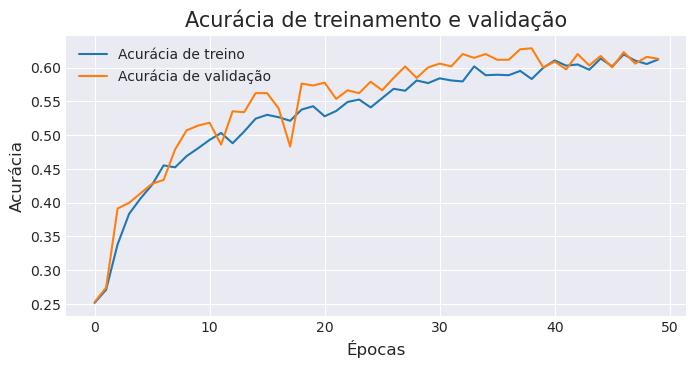

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

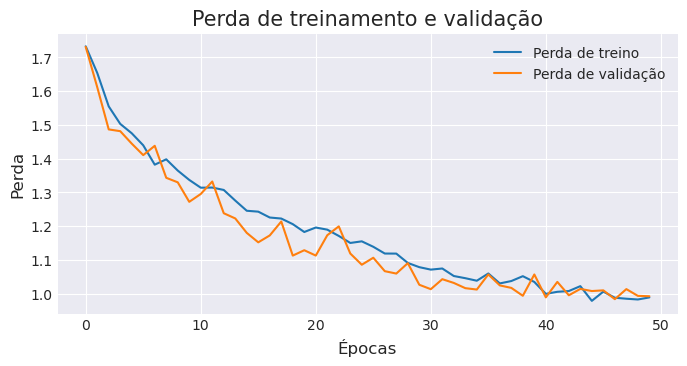

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_03 = keras.models.load_model('best_model_03.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_03.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.6211 - loss: 1.0062
Resultado com dados de teste: accuracy = 0.611299455165863  ;  loss = 1.0413715839385986


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step


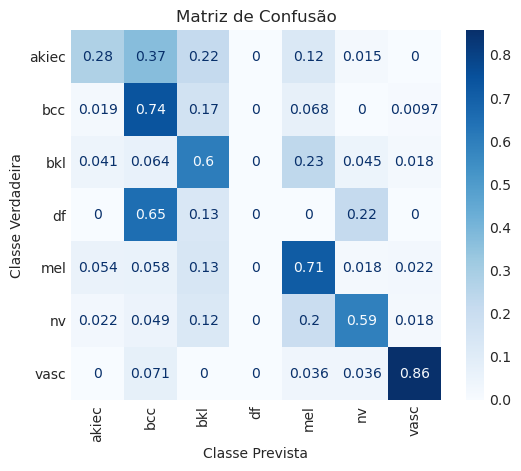

In [ ]:
# previsão no conjunto de teste
predictions = best_model_03.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.39      0.28      0.32        65
           1       0.49      0.74      0.59       103
           2       0.59      0.60      0.60       220
           3       0.00      0.00      0.00        23
           4       0.59      0.71      0.65       223
           5       0.86      0.59      0.70       223
           6       0.63      0.86      0.73        28

    accuracy                           0.61       885
   macro avg       0.51      0.54      0.51       885
weighted avg       0.62      0.61      0.60       885



/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Mesmo com o aumento da camada de convoluções e de camadas densas, o número de parâmetros é menor que o primeiro modelo.

Esta configuração é pior que as anteriores.

### 7.5 [F] - Modelo com 4 convoluções com mais filtros e 8 camadas densas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_04')

In [ ]:
model_04 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(7, activation='softmax')])

In [ ]:
model_04.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_04.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 55, 55, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,767 (6.19 MB)

 Trainable params: 1,621,767 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_04.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50


2024-12-17 08:16:37.143627: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1210', 32 bytes spill stores, 32 bytes spill loads

2024-12-17 08:16:37.441551: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1208', 36 bytes spill stores, 40 bytes spill loads

2024-12-17 08:16:37.645977: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1212', 36 bytes spill stores, 40 bytes spill loads

2024-12-17 08:16:37.652045: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1212', 32 bytes spill stores, 32 bytes spill loads

2024-12-17 08:16:38.206015: I external/local_xla/xla/stream_

29/89 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.2660 - loss: 1.7710

2024-12-17 08:16:51.735548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_709', 8 bytes spill stores, 8 bytes spill loads

2024-12-17 08:16:52.208227: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_723', 8 bytes spill stores, 8 bytes spill loads



88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2635 - loss: 1.7458

2024-12-17 08:17:13.682031: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 8 bytes spill stores, 8 bytes spill loads

2024-12-17 08:17:13.772829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_133', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 1.60089, saving model to best_model_04.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 362ms/step - accuracy: 0.2635 - loss: 1.7450 - val_accuracy: 0.2514 - val_loss: 1.6009
Epoch 2/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3198 - loss: 1.5686
Epoch 2: val_loss improved from 1.60089 to 1.53110, saving model to best_model_04.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.3202 - loss: 1.5688 - val_accuracy: 0.3814 - val_loss: 1.5311
Epoch 3/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3732 - loss: 1.5161
Epoch 3: val_loss improved from 1.53110 to 1.51714, saving model to best_model_04.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.3732 - loss: 1.5163 - val_accuracy: 0.3955 - val_loss: 1.5171
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3957 - loss: 1.5012
Epoch 4: val_loss improved from 1.51714 to 1.47772, saving model to best_model_04.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/st

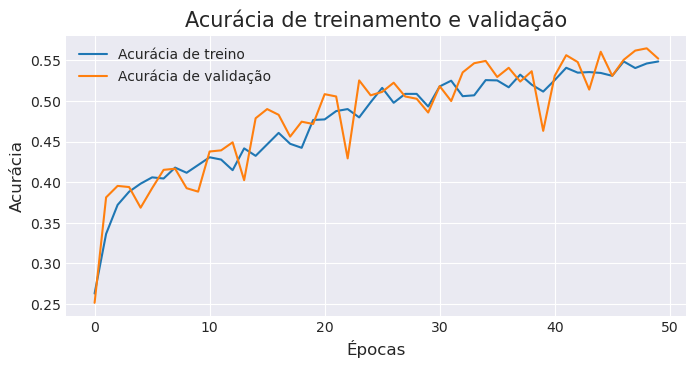

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

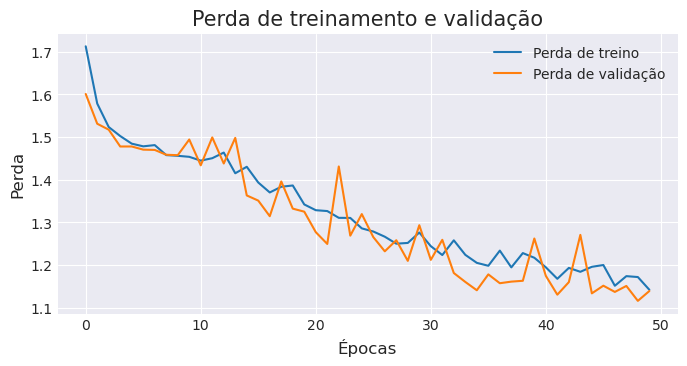

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_04 = keras.models.load_model('best_model_04.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_04.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.5625 - loss: 1.1515
Resultado com dados de teste: accuracy = 0.5514124035835266  ;  loss = 1.1797534227371216


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


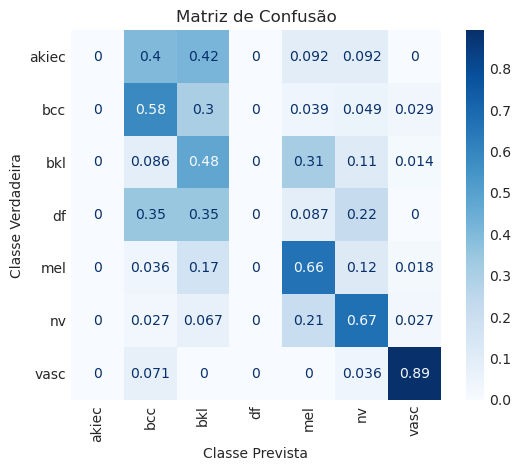

In [ ]:
# previsão no conjunto de teste
predictions = best_model_04.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.47      0.58      0.52       103
           2       0.47      0.48      0.47       220
           3       0.00      0.00      0.00        23
           4       0.54      0.66      0.59       223
           5       0.69      0.67      0.68       223
           6       0.61      0.89      0.72        28

    accuracy                           0.55       885
   macro avg       0.40      0.47      0.43       885
weighted avg       0.50      0.55      0.52       885



/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

**Embora as métricas de perda e acurácia tiveram uma aparência de melhoria, o resultado da predição foi ruim. 2 classes não foram previstas**

### 7.6 [G] - Modelo - 4 convoluções e 8 camadas densas (mais largas)

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_05')

In [ ]:
model_05 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model_05.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_05.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 32)       │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,795,047 (6.85 MB)

 Trainable params: 1,795,047 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_05.fit(
    imagens_treino_under,
    epochs=50,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/50


2024-12-17 08:37:15.062107: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_762', 132 bytes spill stores, 132 bytes spill loads

2024-12-17 08:37:15.351996: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1265', 32 bytes spill stores, 32 bytes spill loads

2024-12-17 08:37:15.415716: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1265', 36 bytes spill stores, 40 bytes spill loads



61/89 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.2300 - loss: 1.7597

2024-12-17 08:37:36.248258: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_762', 4 bytes spill stores, 4 bytes spill loads



89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.2401 - loss: 1.7335
Epoch 1: val_loss improved from inf to 1.53544, saving model to best_model_05.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 356ms/step - accuracy: 0.2405 - loss: 1.7327 - val_accuracy: 0.3927 - val_loss: 1.5354
Epoch 2/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.3567 - loss: 1.5647
Epoch 2: val_loss improved from 1.53544 to 1.48613, saving model to best_model_05.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.3571 - loss: 1.5640 - val_accuracy: 0.4124 - val_loss: 1.4861
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.4101 - loss: 1.4838
Epoch 3: val_loss improved from 1.48613 to 1.47059, saving model to best_model_05.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.4100 - loss: 1.4839 - val_accuracy: 0.4209 - val_loss: 1.4706
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4034 - loss: 1.4686
Epoch 4: val_loss did not improve from 1.47059
89/89 

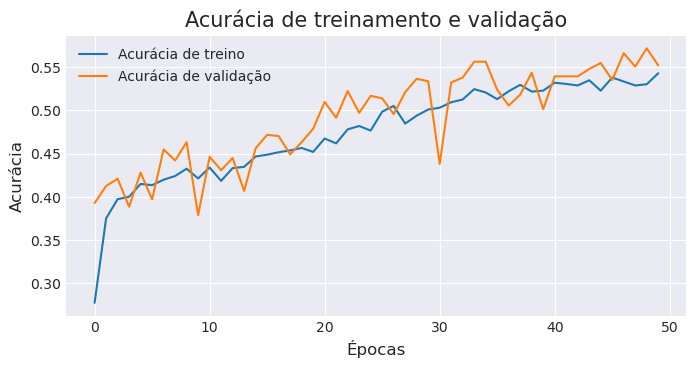

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

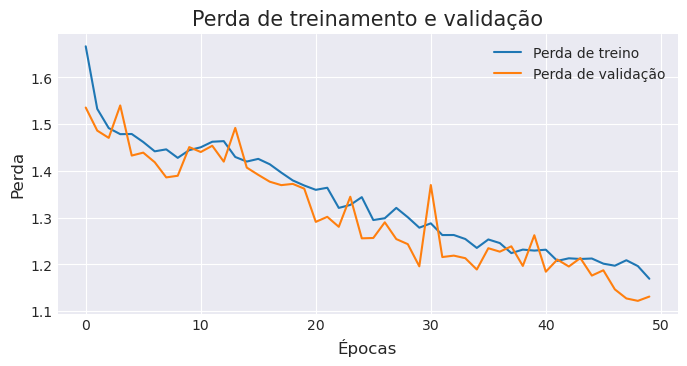

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_05 = keras.models.load_model('best_model_05.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_05.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5698 - loss: 1.1342

2024-12-17 08:57:16.939077: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_140', 32 bytes spill stores, 32 bytes spill loads

2024-12-17 08:57:16.948101: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_140', 12 bytes spill stores, 12 bytes spill loads

2024-12-17 08:57:17.022418: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_140', 200 bytes spill stores, 200 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.5682 - loss: 1.1379
Resultado com dados de teste: accuracy = 0.5457627177238464  ;  loss = 1.1879326105117798


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step


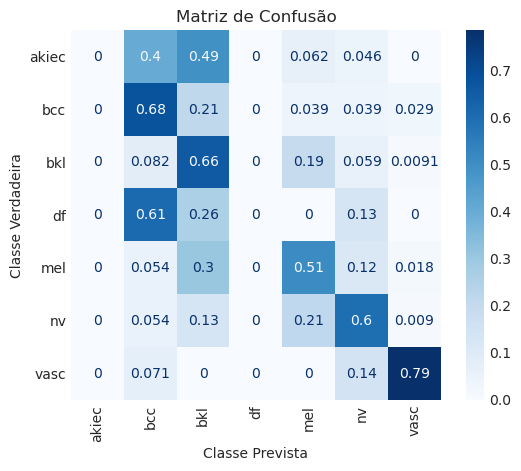

In [ ]:
# previsão no conjunto de teste
predictions = best_model_05.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.45      0.68      0.54       103
           2       0.48      0.66      0.56       220
           3       0.00      0.00      0.00        23
           4       0.54      0.51      0.52       223
           5       0.72      0.60      0.65       223
           6       0.67      0.79      0.72        28

    accuracy                           0.55       885
   macro avg       0.41      0.46      0.43       885
weighted avg       0.51      0.55      0.52       885



/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Ainda apresenta resultados médios piores que o primeiro modelo

## 8 Treinamento de modelos com mais épocas

**Tentativa de aumento de épocas para tentar aumentar o aprendizado.**

### 8.1 [H] - Modelo [B] com treinamento em 100 épocas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_01_100')

In [ ]:
# definição do modelo
model_01 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),

    keras.layers.Dense(7, activation='softmax')
])

## compilação
model_01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,500,935 (24.80 MB)

 Trainable params: 6,500,935 (24.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_01.fit(
    imagens_treino_under,
    epochs=100,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.3212 - loss: 1.7483
Epoch 1: val_loss improved from inf to 1.54646, saving model to best_model_01_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - accuracy: 0.3221 - loss: 1.7458 - val_accuracy: 0.4280 - val_loss: 1.5465
Epoch 2/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4227 - loss: 1.5515
Epoch 2: val_loss improved from 1.54646 to 1.45624, saving model to best_model_01_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.4228 - loss: 1.5508 - val_accuracy: 0.4590 - val_loss: 1.4562
Epoch 3/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.4379 - loss: 1.4731
Epoch 3: val_loss improved from 1.45624 to 1.40931, saving model to best_model_01_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - accuracy: 0.4380 - loss: 1.4727 - val_accuracy: 0.4463 - val_loss: 1.4093
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4597 - loss: 1.4372
Epoch 4: val_loss did not 

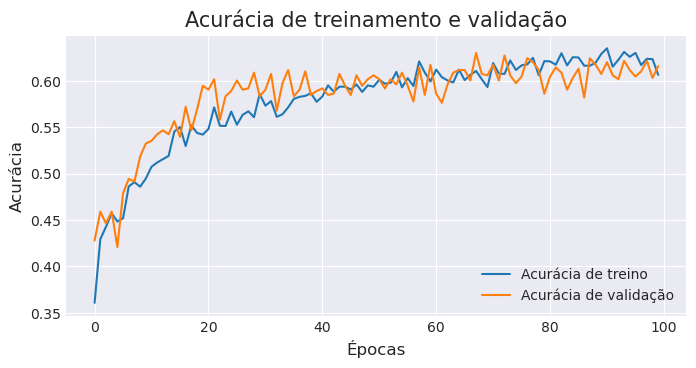

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

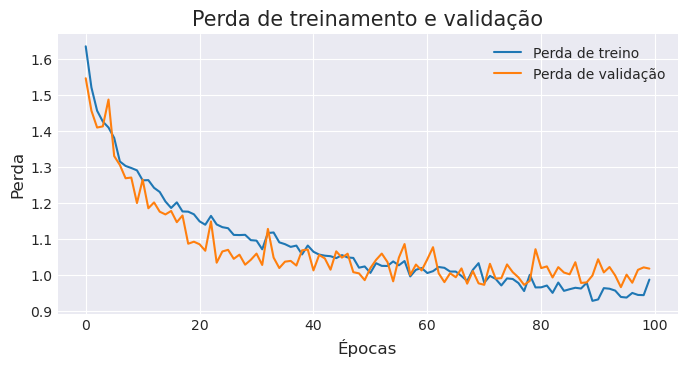

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_01 = keras.models.load_model('best_model_01_100.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_01.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.6344 - loss: 1.0016
Resultado com dados de teste: accuracy = 0.6158192157745361  ;  loss = 1.0359163284301758


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step


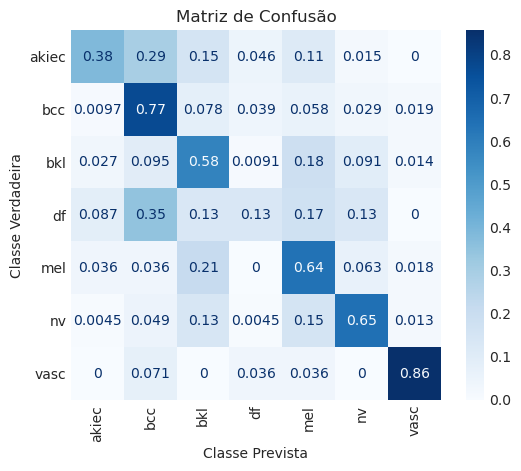

In [ ]:
# previsão no conjunto de teste
predictions = best_model_01.predict(imagens_teste_under) #### mudei depois de rodar
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.58      0.38      0.46        65
           1       0.53      0.77      0.63       103
           2       0.57      0.58      0.57       220
           3       0.21      0.13      0.16        23
           4       0.61      0.64      0.62       223
           5       0.78      0.65      0.71       223
           6       0.67      0.86      0.75        28

    accuracy                           0.62       885
   macro avg       0.56      0.57      0.56       885
weighted avg       0.62      0.62      0.61       885



### 8.2 [I] - Modelo [E] com treinamento de 100 épocas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_02_100')

In [ ]:
model_03 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

## compilação
model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_03.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,231 (1.27 MB)

 Trainable params: 332,231 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## treinamento
history = model_03.fit(
    imagens_treino_under,
    epochs=100,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2437 - loss: 1.7750
Epoch 1: val_loss improved from inf to 1.68796, saving model to best_model_02_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.2442 - loss: 1.7738 - val_accuracy: 0.3418 - val_loss: 1.6880
Epoch 2/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.3573 - loss: 1.5862
Epoch 2: val_loss improved from 1.68796 to 1.48770, saving model to best_model_02_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.3579 - loss: 1.5849 - val_accuracy: 0.4167 - val_loss: 1.4877
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3802 - loss: 1.4999
Epoch 3: val_loss improved from 1.48770 to 1.48410, saving model to best_model_02_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.3802 - loss: 1.5000 - val_accuracy: 0.3771 - val_loss: 1.4841
Epoch 4/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.3823 - loss: 1.5111
Epoch 4: val_loss improved

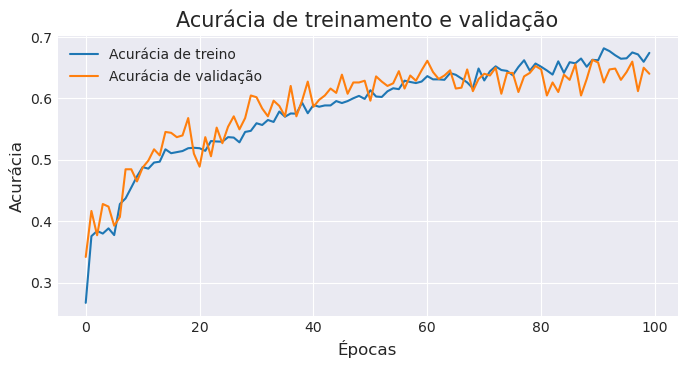

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

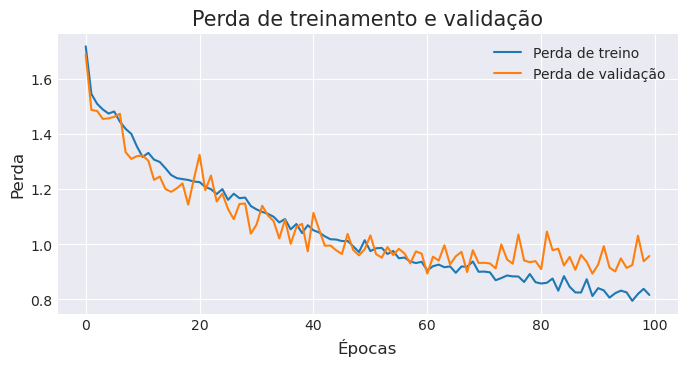

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_02_100 = keras.models.load_model('best_model_02_100.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_02_100.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.6555 - loss: 0.9543
Resultado com dados de teste: accuracy = 0.6372881531715393  ;  loss = 0.9912330508232117


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step


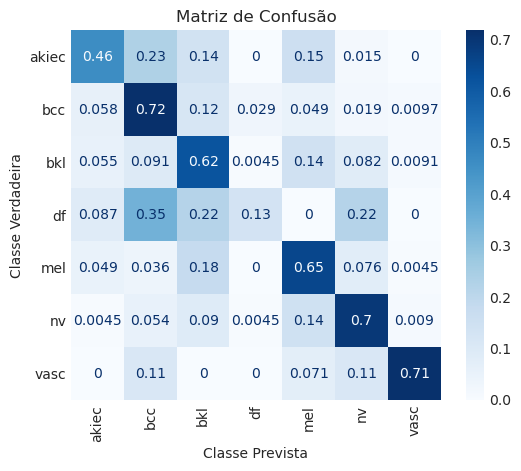

In [ ]:
# previsão no conjunto de teste
predictions = best_model_02_100.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47        65
           1       0.53      0.72      0.61       103
           2       0.61      0.62      0.62       220
           3       0.38      0.13      0.19        23
           4       0.65      0.65      0.65       223
           5       0.77      0.70      0.73       223
           6       0.77      0.71      0.74        28

    accuracy                           0.64       885
   macro avg       0.60      0.57      0.57       885
weighted avg       0.64      0.64      0.64       885



### 8.3 Modelo I com mudança de função de perda e de otimização

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_dp_100')

In [ ]:
model_04_dp = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax')])

model_04_dp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_04_dp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 55, 55, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             

 Total params: 1,621,767 (6.19 MB)

 Trainable params: 1,621,767 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## treinamento
history = model_04_dp.fit(
    imagens_treino_under,
    epochs=100,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao_under,
    callbacks=[checkpoint])

Epoch 1/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.2358 - loss: 1.8337
Epoch 1: val_loss improved from inf to 1.66731, saving model to best_model_dp_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - accuracy: 0.2361 - loss: 1.8322 - val_accuracy: 0.2514 - val_loss: 1.6673
Epoch 2/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2903 - loss: 1.6504
Epoch 2: val_loss improved from 1.66731 to 1.55664, saving model to best_model_dp_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.2910 - loss: 1.6502 - val_accuracy: 0.4138 - val_loss: 1.5566
Epoch 3/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3676 - loss: 1.6003
Epoch 3: val_loss improved from 1.55664 to 1.51328, saving model to best_model_dp_100.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.3675 - loss: 1.6002 - val_accuracy: 0.3884 - val_loss: 1.5133
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3675 - loss: 1.5920
Epoch 4: val_loss did not 

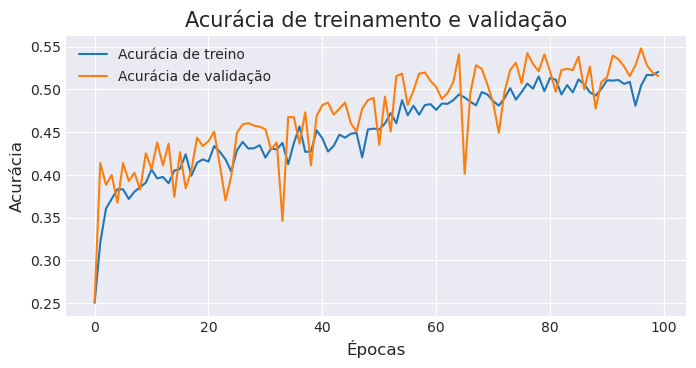

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

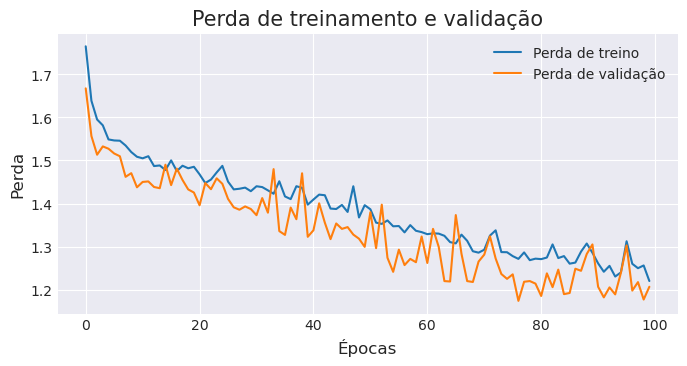

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_04_dp = keras.models.load_model('best_model_dp_100.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_04_dp.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.5403 - loss: 1.1958
Resultado com dados de teste: accuracy = 0.5389830470085144  ;  loss = 1.2373229265213013


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step


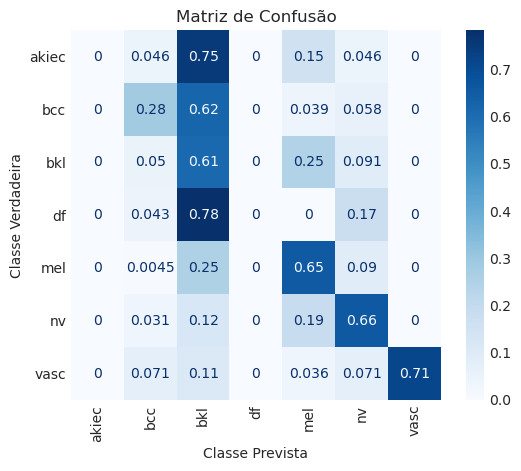

In [ ]:
# previsão no conjunto de teste
predictions = best_model_04_dp.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.54      0.28      0.37       103
           2       0.38      0.61      0.47       220
           3       0.00      0.00      0.00        23
           4       0.57      0.65      0.61       223
           5       0.73      0.66      0.69       223
           6       1.00      0.71      0.83        28

    accuracy                           0.54       885
   macro avg       0.46      0.42      0.42       885
weighted avg       0.52      0.54      0.51       885



/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

**Esses foram os modelos possíveis de treinamento dentro das possibilidades de hardware treinando do zero.**

### 8.4 modelo 4 conv e 4 densas

In [ ]:
checkpoint = limpeza_para_treinamento('best_model_03_100')

In [ ]:
model_03 = keras.models.Sequential([
    keras.layers.Input(shape=(120, 120, 3)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_03.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,231 (1.27 MB)

 Trainable params: 332,231 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_03.fit(
    imagens_treino,
    epochs=100,  # Pode ajustar conforme necessário
    validation_data=imagens_validacao,
    callbacks=[checkpoint])

Epoch 1/100


/home/dudu/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6496 - loss: 1.2246
Epoch 1: val_loss improved from inf to 1.23533, saving model to best_model_03_100.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 63s 294ms/step - accuracy: 0.6497 - loss: 1.2241 - val_accuracy: 0.6694 - val_loss: 1.2353
Epoch 2/100
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6675 - loss: 1.0432
Epoch 2: val_loss improved from 1.23533 to 0.97220, saving model to best_model_03_100.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.6675 - loss: 1.0430 - val_accuracy: 0.6694 - val_loss: 0.9722
Epoch 3/100
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6733 - loss: 0.9788
Epoch 3: val_loss did not improve from 0.97220
201/201 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.6733 - loss: 0.9789 - val_accuracy: 0.6694 - val_loss: 1.0179
Epoch 4/100
200/201 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6663 - loss: 0.9555
Epoch 4: val_loss improved from 0.97220 to 0.93071, saving model to b

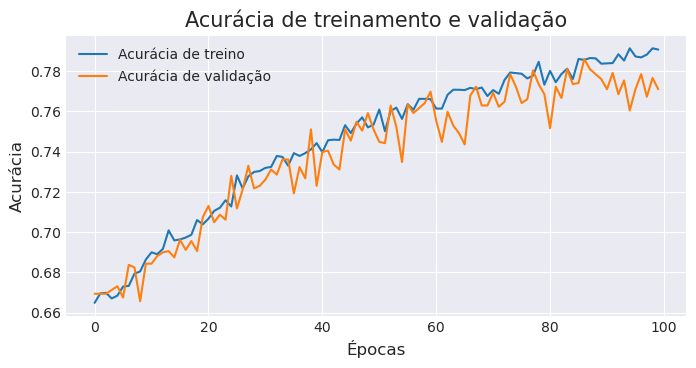

In [ ]:
# acurácia de treino e validação
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

grafico_desempenho_redes(acc, val_acc, "Acurácia")

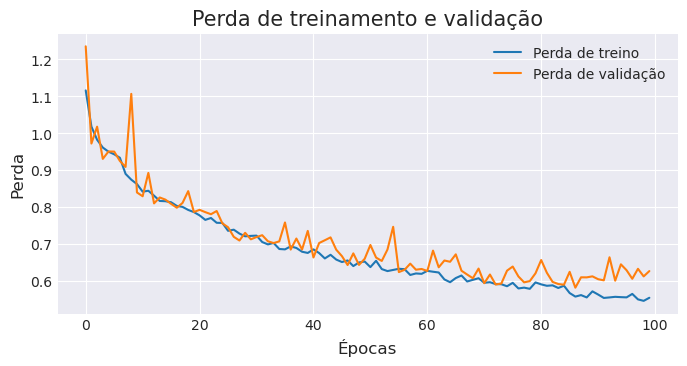

In [ ]:
# perda de treinamento e validação
loss = history.history["loss"]
val_loss = history.history["val_loss"]

grafico_desempenho_redes(loss, val_loss, "Perda")

In [ ]:
# carregamento do melhor modelo
best_model_03 = keras.models.load_model('best_model_03_100.keras')

# Melhor modelo do treinamento
test_loss, test_acc = best_model_03.evaluate(imagens_teste_under, verbose=1)
print(f"Resultado com dados de teste: accuracy = {test_acc}  ;  loss = {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.5487 - loss: 1.1155
Resultado com dados de teste: accuracy = 0.5581920742988586  ;  loss = 1.133278489112854


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step


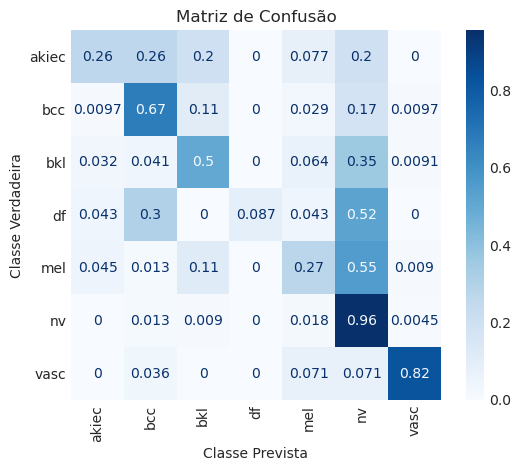

In [ ]:
# previsão no conjunto de teste
predictions = best_model_03.predict(imagens_teste_under)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = imagens_teste_under.classes

matriz_confusao(true_labels, predicted_labels)

In [ ]:
# Imprimir o relatório de métricas
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.47      0.26      0.34        65
           1       0.63      0.67      0.65       103
           2       0.68      0.50      0.58       220
           3       1.00      0.09      0.16        23
           4       0.67      0.27      0.38       223
           5       0.46      0.96      0.62       223
           6       0.79      0.82      0.81        28

    accuracy                           0.56       885
   macro avg       0.67      0.51      0.51       885
weighted avg       0.62      0.56      0.53       885

